<a href="https://colab.research.google.com/github/arif-hussain09/100-days-of-machine-learning/blob/main/step_1(UNIVERSAL_FACE_SHIELD).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DEEP DIVING <- Step 1 (PGD and face detection )

In [50]:
# === Cell 1: Mount Google Drive & Create Project Directory ===
from google.colab import drive
import os

drive.mount('/content/drive')

PROJECT_PATH = "/content/drive/MyDrive/BTech_Aegis_Project"
DATA_PATH = os.path.join(PROJECT_PATH, "data")
OUTPUT_PATH = os.path.join(PROJECT_PATH, "output")
os.makedirs(PROJECT_PATH, exist_ok=True)
os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(OUTPUT_PATH, exist_ok=True)
print(f"Project directory created at: {PROJECT_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project directory created at: /content/drive/MyDrive/BTech_Aegis_Project


In [ ]:
# === Cell 2: Install Required Libraries ===
!pip install lz4 # Install LZ4 FIRST
!pip install mtcnn # Install MTCNN AFTER LZ4
!pip install torch torchvision --upgrade
!pip install pillow matplotlib numpy
!pip install diffusers transformers accelerate
!pip install scikit-learn lpips
!pip install tensorflow # Keep TF commented out unless MTCNN specifically asks for it later

print("Libraries potentially reinstalled successfully.")
print("!!! IMPORTANT: PLEASE RESTART YOUR COLAB RUNTIME NOW !!!")
print("!!! (Go to Runtime -> Restart Runtime) BEFORE running the next cell !!!")

print("Libraries installed successfully.")

Libraries potentially reinstalled successfully.
!!! IMPORTANT: PLEASE RESTART YOUR COLAB RUNTIME NOW !!!
!!! (Go to Runtime -> Restart Runtime) BEFORE running the next cell !!!
Libraries installed successfully.


In [ ]:
# === Cell 3: Import All Necessary Libraries ===
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from google.colab import files
from tqdm.auto import tqdm
from mtcnn import MTCNN
from diffusers import AutoencoderKL
import gc
import lpips
print("Libraries imported.")

Libraries imported.


In [ ]:
# === Cell 4: Initialize Device ===
# (Simplified - no YOLO model needed for main path)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cpu_device = torch.device('cpu')
print(f"Main device: {device}")
print(f"Secondary device: {cpu_device}")



Main device: cuda:0
Secondary device: cpu


In [ ]:
# === Cell 5: Upload Your Test Image ===
print("Please upload your test image:")
uploaded = files.upload()
TEST_IMAGE_NAME = list(uploaded.keys())[0]
TEST_IMAGE_PATH = os.path.join(DATA_PATH, TEST_IMAGE_NAME)
with open(TEST_IMAGE_PATH, 'wb') as f:
    f.write(uploaded[TEST_IMAGE_NAME])
print(f"Image '{TEST_IMAGE_NAME}' uploaded and saved to {TEST_IMAGE_PATH}")

Please upload your test image:


Saving srk.webp to srk (3).webp
Image 'srk (3).webp' uploaded and saved to /content/drive/MyDrive/BTech_Aegis_Project/data/srk (3).webp


In [ ]:
import lz4
!lz4 --version


/bin/bash: line 1: lz4: command not found


In [ ]:
# === Cell 6: REVISED - Step 1: Face Detection using MTCNN ===

print("Performing face detection using MTCNN...")
# Load the image using PIL (MTCNN uses numpy array)
img_pil_orig = Image.open(TEST_IMAGE_PATH).convert('RGB')
img_np_orig = np.array(img_pil_orig)

# Initialize MTCNN detector
# It might run on CPU or GPU depending on backend availability
# Let's keep it simple on CPU for reliability
detector = MTCNN()

# Detect faces
# The result is a list of dictionaries, each containing 'box': [x, y, width, height]
faces = detector.detect_faces(img_np_orig)

img_h, img_w = img_np_orig.shape[:2]
mask_np = np.zeros((img_h, img_w), dtype=np.uint8) # Create mask

if len(faces) > 0:
    print(f"Detected {len(faces)} face(s). Creating mask...")
    for face in faces:
        # Extract bounding box
        x, y, w, h = face['box']
        # Add padding (optional, adjust as needed)
        padding_w = int(0.1 * w)
        padding_h = int(0.1 * h)
        x1 = max(0, x - padding_w)
        y1 = max(0, y - padding_h)
        x2 = min(img_w - 1, x + w + padding_w)
        y2 = min(img_h - 1, y + h + padding_h)

        # Ensure coordinates are valid integers
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])

        # Fill the face region in the mask
        if x1 < x2 and y1 < y2:
            mask_np[y1:y2, x1:x2] = 1

    if mask_np.sum() == 0: # Check if masking actually happened
         print("Face detection resulted in empty mask after padding/rounding. Defaulting to full mask.")
         mask_np = np.ones((img_h, img_w), dtype=np.uint8)

else:
    print("No faces detected by MTCNN. Defaulting to full image mask.")
    mask_np = np.ones((img_h, img_w), dtype=np.uint8) # Default to full mask

# MTCNN object `detector` might hold models, delete it if memory is tight
del detector
gc.collect()
torch.cuda.empty_cache()

Performing face detection using MTCNN...
Detected 1 face(s). Creating mask...


Using resolution: 512x512
Image, Mask (FACE ONLY?), and Delta tensors created on GPU (512x512, torch.float32).
Mask tensor shape: torch.Size([1, 1, 512, 512]), Sum: 18354.0


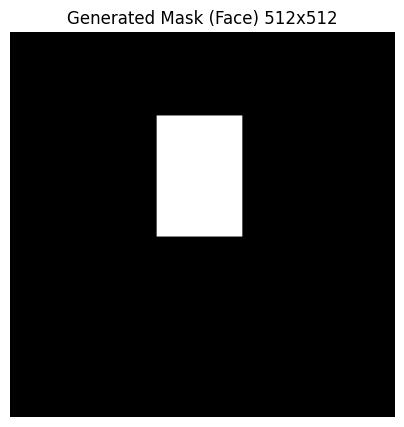

In [ ]:

# === Cell 7: Helper Functions & Tensor Setup (512x512) ===
RESOLUTION = 512
print(f"Using resolution: {RESOLUTION}x{RESOLUTION}")

def to_tensor(img_array):
    # Convert numpy array (H, W, C) in range [0, 255] to torch tensor (C, H, W) in range [0, 1]
    img_tensor = torch.from_numpy(img_array).float() / 255.0
    img_tensor = img_tensor.permute(2, 0, 1) # HWC to CHW
    return img_tensor.to(device)

def to_numpy(img_tensor):
    # Convert torch tensor (B, C, H, W) or (C, H, W) in range [0, 1] to numpy array (H, W, C) in range [0, 255]
    if img_tensor.dtype != torch.float32:
        img_tensor = img_tensor.float() # Convert from float16 if necessary
    if img_tensor.dim() == 4:
        img_tensor = img_tensor[0] # Remove batch dim
    # Move tensor to CPU before converting to numpy
    img_np = img_tensor.permute(1, 2, 0).clamp(0, 1).mul(255).byte().cpu().numpy() # CHW to HWC
    return img_np

def tensor_to_pil(img_tensor):
    return Image.fromarray(to_numpy(img_tensor))

# Use the original PIL image for resizing consistency
img_pil = Image.open(TEST_IMAGE_PATH).convert('RGB')
img_pil_resized = img_pil.resize((RESOLUTION, RESOLUTION), Image.LANCZOS)

# Check if mask_np was successfully created before resizing
if mask_np is None:
     print("ERROR: mask_np was not created. Cannot proceed.")
     # Handle error or exit
     mask_pil_resized = Image.new('L', (RESOLUTION, RESOLUTION), color=255) # Default full white mask
     mask_np_resized = np.array(mask_pil_resized, dtype=np.uint8)
else:
     mask_pil_resized = Image.fromarray(mask_np).resize((RESOLUTION, RESOLUTION), Image.NEAREST)
     mask_np_resized = np.array(mask_pil_resized)


img_np_resized = np.array(img_pil_resized)


dtype_attack = torch.float32 # Use float32 for Adam and LPIPS stability
image_tensor = to_tensor(img_np_resized).unsqueeze(0).to(dtype_attack) # Add batch dim B=1
mask_tensor = torch.from_numpy(mask_np_resized).float().unsqueeze(0).unsqueeze(0).to(device).to(dtype_attack) # Add B=1, C=1
delta = (torch.rand_like(image_tensor) * 2 - 1) * 0.001 # Start with tiny random noise [-0.001, 0.001]
delta = delta.to(dtype_attack)
delta.requires_grad_(True)
print(f"Image, Mask (FACE ONLY?), and Delta tensors created on GPU ({RESOLUTION}x{RESOLUTION}, {dtype_attack}).")
print(f"Mask tensor shape: {mask_tensor.shape}, Sum: {mask_tensor.sum().item()}") # Check mask content

# Visualize the mask to confirm
plt.figure(figsize=(5,5))
plt.imshow(mask_np_resized, cmap='gray')
plt.title(f"Generated Mask ({'Face' if mask_np.sum()>0 and mask_np.mean()<1 else 'Full'}) {RESOLUTION}x{RESOLUTION}")
plt.axis('off')
plt.show()

def normalize(img_tensor):
    # Normalize image tensor from [0, 1] to [-1, 1]
    return img_tensor * 2.0 - 1.0

def denormalize(img_tensor):
    # Denormalize image tensor from [-1, 1] back to [0, 1]
    return (img_tensor + 1.0) / 2.0

In [ ]:
# === Cell 8: Load VAE Model and LPIPS Model ===
MODEL_ID_VAE = "runwayml/stable-diffusion-v1-5"
print(f"Loading VAE ({MODEL_ID_VAE})... (to GPU, {dtype_attack})")
vae = AutoencoderKL.from_pretrained(
    MODEL_ID_VAE, subfolder="vae", torch_dtype=dtype_attack
).to(device)
vae.requires_grad_(False)
vae.eval()
try:
    scaling_factor = vae.config.scaling_factor
except AttributeError:
    scaling_factor = 0.18215 # Default for SD v1.x VAEs
print(f"VAE loaded to GPU. Scaling factor: {scaling_factor}")

print(f"Loading LPIPS model... (to GPU)")
lpips_loss_fn = lpips.LPIPS(net='alex').to(device)
lpips_loss_fn.requires_grad_(False)
lpips_loss_fn.eval()
print("LPIPS model loaded to GPU.")

Loading VAE (runwayml/stable-diffusion-v1-5)... (to GPU, torch.float32)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


VAE loaded to GPU. Scaling factor: 0.18215
Loading LPIPS model... (to GPU)
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
LPIPS model loaded to GPU.


In [ ]:
# === Cell 9: REVISED - Step 2: Adam + PGD Optimization Loop with Tracking ===

LEARNING_RATE = 0.005
NUM_STEPS = 500 # Increased steps
EPSILON = 0.03
W_VAE = 0.5
W_LPIPS = 1.5 # Increased LPIPS weight for better imperceptibility
LOG_INTERVAL = 20 # Log metrics every 20 steps

optimizer = torch.optim.Adam([delta], lr=LEARNING_RATE)

# --- Initialize Tracking Lists ---
tracked_steps = []
tracked_total_loss = []
tracked_vae_loss = []
tracked_lpips_loss = []
tracked_l2_dist = []
tracked_cosine_dist = []

print(f"Starting Adam+PGD optimization (VAE + LPIPS, MTCNN FACE ONLY): {NUM_STEPS} steps, EPSILON={EPSILON}, W_LPIPS={W_LPIPS}...")
pbar = tqdm(range(NUM_STEPS))

with torch.no_grad():
    clean_img_norm_vae = normalize(image_tensor)
    z_clean = vae.encode(clean_img_norm_vae).latent_dist.mode() * scaling_factor
    z_clean_flat = z_clean.view(z_clean.size(0), -1) # Pre-flatten for distance calcs
    print("Calculated clean latent vector.")

# --- Optimization Loop ---
for step in pbar:
    optimizer.zero_grad()
    perturbed_image = torch.clamp(image_tensor + (delta * mask_tensor), 0, 1)

    # VAE Loss
    perturbed_img_norm_vae = normalize(perturbed_image)
    z_poisoned = vae.encode(perturbed_img_norm_vae).latent_dist.mode() * scaling_factor
    loss_vae = -F.mse_loss(z_poisoned, z_clean)

    # LPIPS Loss
    loss_lpips = lpips_loss_fn(perturbed_image, image_tensor).mean()

    # Combined Loss
    total_loss = (W_VAE * loss_vae) + (W_LPIPS * loss_lpips)

    total_loss.backward()
    optimizer.step()

    # PGD Projection
    with torch.no_grad():
        delta.data = torch.clamp(delta.data, -EPSILON, EPSILON)
        delta.data *= mask_tensor

    # --- Log Metrics ---
    if step % LOG_INTERVAL == 0 or step == NUM_STEPS - 1:
        with torch.no_grad():
            # Recalculate z_poisoned for current delta to get accurate distances
            z_poisoned_current = vae.encode(normalize(perturbed_image)).latent_dist.mode() * scaling_factor
            z_poisoned_flat_current = z_poisoned_current.view(z_poisoned_current.size(0), -1)

            l2_dist_current = torch.norm(z_clean_flat - z_poisoned_flat_current, p=2).item()
            cosine_sim_current = F.cosine_similarity(z_clean_flat, z_poisoned_flat_current).item()
            cosine_dist_current = 1 - cosine_sim_current

            tracked_steps.append(step)
            tracked_total_loss.append(total_loss.item())
            tracked_vae_loss.append(loss_vae.item())
            tracked_lpips_loss.append(loss_lpips.item())
            tracked_l2_dist.append(l2_dist_current)
            tracked_cosine_dist.append(cosine_dist_current)

            pbar.set_description(f"Step {step}, L2: {l2_dist_current:.2f}, Cos D: {cosine_dist_current:.2f}, LPIPS: {loss_lpips.item():.4f}")

    del perturbed_image, perturbed_img_norm_vae, z_poisoned, loss_vae, loss_lpips, total_loss
    if device.type == 'cuda': torch.cuda.empty_cache()

print("Adam+PGD optimization complete.")
delta_final = delta.detach()

Starting Adam+PGD optimization (VAE + LPIPS, MTCNN FACE ONLY): 500 steps, EPSILON=0.03, W_LPIPS=1.0...


  0%|          | 0/500 [00:00<?, ?it/s]

Calculated clean latent vector.
Adam+PGD optimization complete.


In [ ]:
# === Cell 10: Step 3: Final Analysis (Distances ONLY) ===
# (This now just prints the final values from the tracked lists)
print("\n--- Step 3: Final Latent Space Analysis ---")
final_l2 = tracked_l2_dist[-1]
final_cosine = tracked_cosine_dist[-1]
print(f"Final L2 Distance: {final_l2:.4f}")
print(f"Final Cosine Distance: {final_cosine:.4f}")


--- Step 3: Final Latent Space Analysis ---
Final L2 Distance: 51.6001
Final Cosine Distance: 0.0726



Visualizing final results...


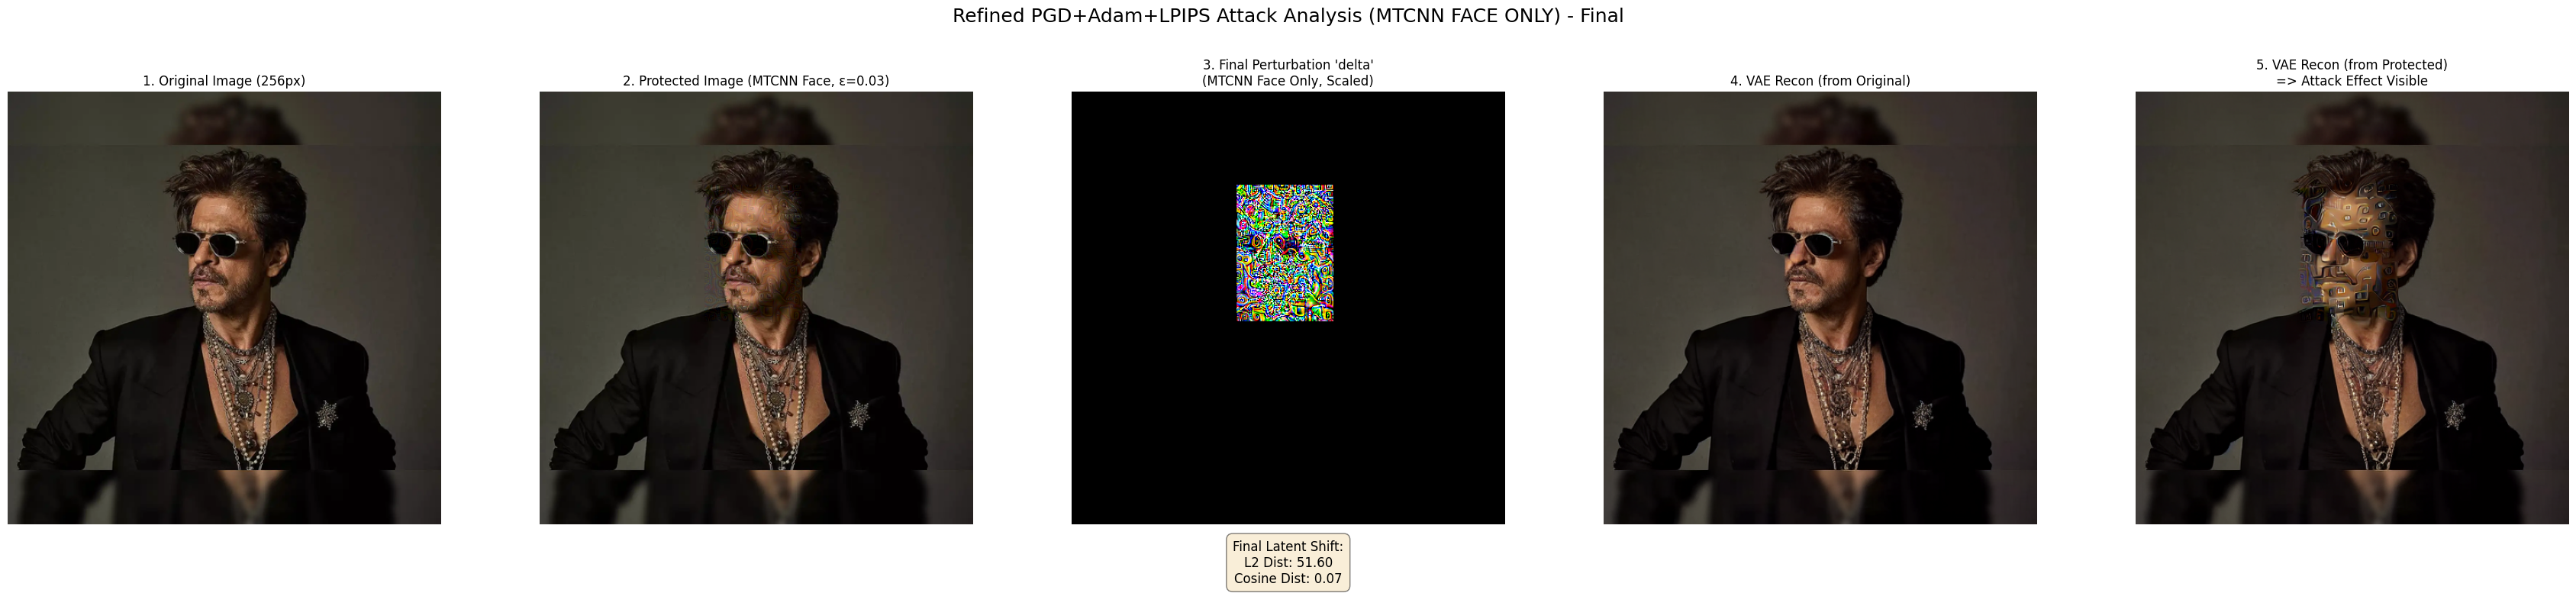


Plotting optimization progress...


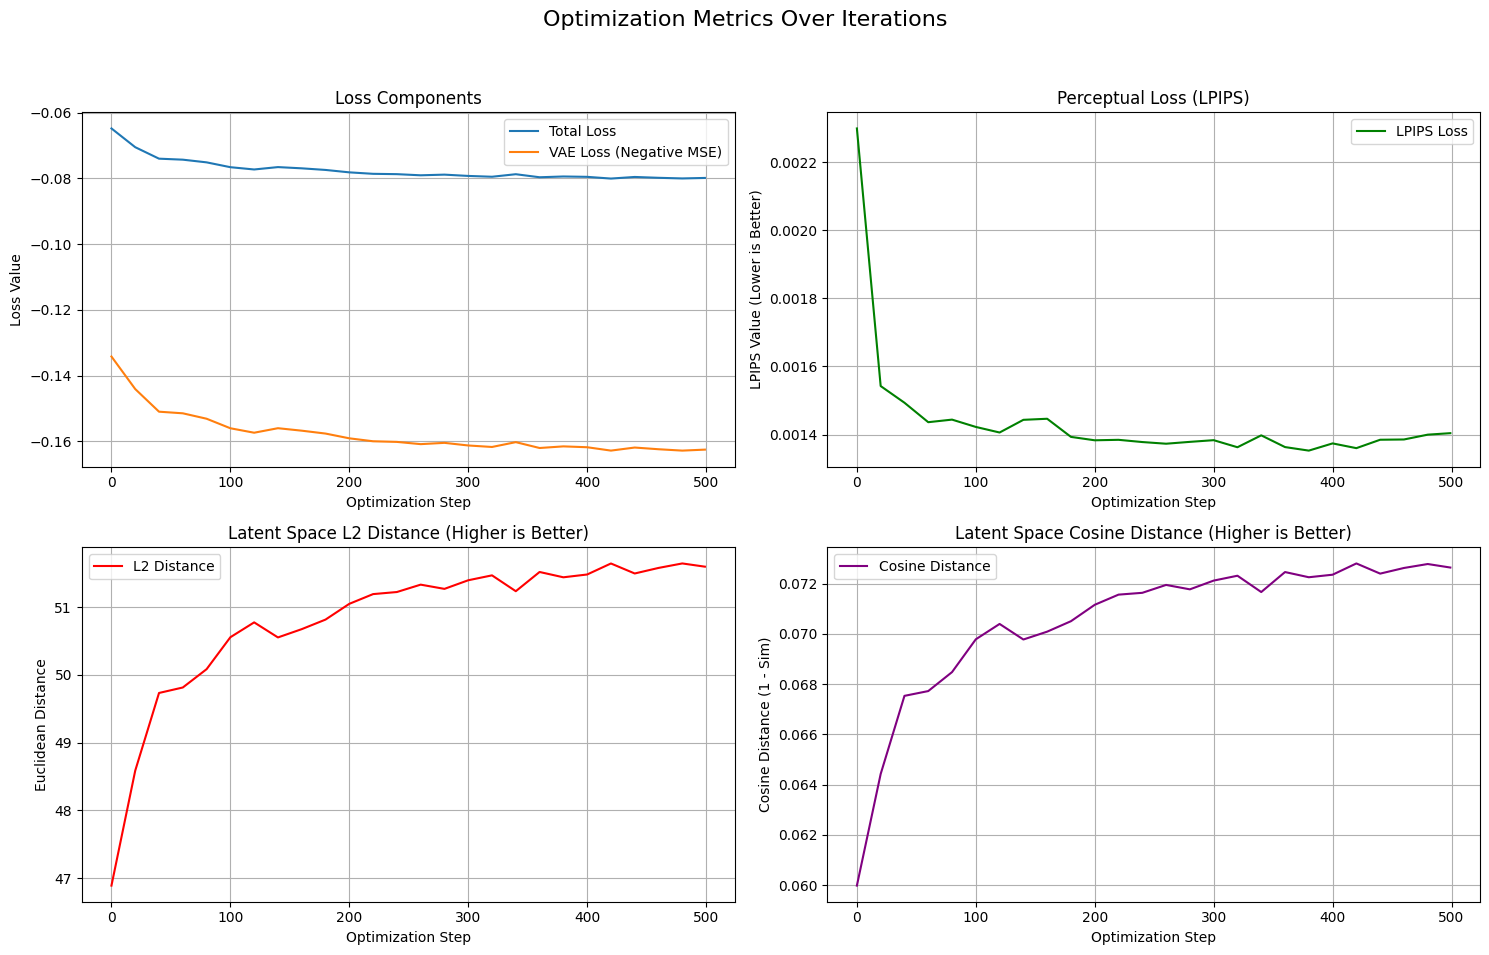


Saved protected image to: /content/drive/MyDrive/BTech_Aegis_Project/output/step2_mtcnn_tracked_protected_256.png
Saved VAE reconstruction proof to: /content/drive/MyDrive/BTech_Aegis_Project/output/step2_mtcnn_tracked_vae_proof_256.png
Saved delta visualization to: /content/drive/MyDrive/BTech_Aegis_Project/output/step2_mtcnn_tracked_delta_vis_256.png
Saved analysis plot to: /content/drive/MyDrive/BTech_Aegis_Project/output/step2_mtcnn_tracked_analysis_plot_256.png
Saved metrics plot to: /content/drive/MyDrive/BTech_Aegis_Project/output/step2_mtcnn_tracked_metrics_plot_256.png

Refined Step 1 (MTCNN Face Detect) & Step 2 complete with Metric Tracking.
Final L2 Distance: 51.6001, Final Cosine Distance: 0.0726


In [ ]:
# === Cell 11: Visualization (Final Images) ===
# (Plot final images as before)
print("\nVisualizing final results...")

with torch.no_grad():
    protected_image_tensor = torch.clamp(image_tensor + (delta_final * mask_tensor), 0, 1)
    # Use z_clean calculated earlier for clean recon
    recon_clean_norm = vae.decode(z_clean / scaling_factor).sample
    recon_clean = denormalize(recon_clean_norm)
    # Recalculate final z_poisoned for poisoned recon
    protected_img_norm_final = normalize(protected_image_tensor)
    z_poisoned_final = vae.encode(protected_img_norm_final).latent_dist.mode() * scaling_factor
    recon_poison_norm = vae.decode(z_poisoned_final / scaling_factor).sample
    recon_poison = denormalize(recon_poison_norm)

fig, ax = plt.subplots(1, 5, figsize=(35, 7))
plt.suptitle("Refined PGD+Adam+LPIPS Attack Analysis (MTCNN FACE ONLY) - Final", fontsize=18, y=1.02)
# ... (plotting code identical to previous version) ...
ax[0].imshow(to_numpy(image_tensor))
ax[0].set_title("1. Original Image (256px)")
ax[0].axis('off')
ax[1].imshow(to_numpy(protected_image_tensor))
ax[1].set_title(f"2. Protected Image (MTCNN Face, ε={EPSILON})")
ax[1].axis('off')
delta_visualization = delta_final.data.clone()
delta_vis_scaled = (delta_visualization + EPSILON) / (2 * EPSILON)
delta_vis_scaled *= mask_tensor
ax[2].imshow(to_numpy(delta_vis_scaled), cmap='gray')
ax[2].set_title("3. Final Perturbation 'delta'\n(MTCNN Face Only, Scaled)")
ax[2].axis('off')
ax[3].imshow(to_numpy(recon_clean))
ax[3].set_title("4. VAE Recon (from Original)")
ax[3].axis('off')
ax[4].imshow(to_numpy(recon_poison))
ax[4].set_title("5. VAE Recon (from Protected)\n=> Attack Effect Visible")
ax[4].axis('off')
distance_text = f"Final Latent Shift:\nL2 Dist: {final_l2:.2f}\nCosine Dist: {final_cosine:.2f}"
fig.text(0.5, -0.02, distance_text, ha='center', va='center', fontsize=12, bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))
plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

# === Cell 12: NEW - Plot Tracked Metrics ===
print("\nPlotting optimization progress...")
fig_metrics, axes = plt.subplots(2, 2, figsize=(15, 10))
plt.suptitle("Optimization Metrics Over Iterations", fontsize=16)

# Plot Losses
axes[0, 0].plot(tracked_steps, tracked_total_loss, label='Total Loss')
axes[0, 0].plot(tracked_steps, tracked_vae_loss, label='VAE Loss (Negative MSE)')
axes[0, 0].set_xlabel("Optimization Step")
axes[0, 0].set_ylabel("Loss Value")
axes[0, 0].set_title("Loss Components")
axes[0, 0].legend(); axes[0, 0].grid(True)

axes[0, 1].plot(tracked_steps, tracked_lpips_loss, label='LPIPS Loss', color='green')
axes[0, 1].set_xlabel("Optimization Step")
axes[0, 1].set_ylabel("LPIPS Value (Lower is Better)")
axes[0, 1].set_title("Perceptual Loss (LPIPS)")
axes[0, 1].legend(); axes[0, 1].grid(True)

# Plot Distances
axes[1, 0].plot(tracked_steps, tracked_l2_dist, label='L2 Distance', color='red')
axes[1, 0].set_xlabel("Optimization Step")
axes[1, 0].set_ylabel("Euclidean Distance")
axes[1, 0].set_title("Latent Space L2 Distance (Higher is Better)")
axes[1, 0].legend(); axes[1, 0].grid(True)

axes[1, 1].plot(tracked_steps, tracked_cosine_dist, label='Cosine Distance', color='purple')
axes[1, 1].set_xlabel("Optimization Step")
axes[1, 1].set_ylabel("Cosine Distance (1 - Sim)")
axes[1, 1].set_title("Latent Space Cosine Distance (Higher is Better)")
axes[1, 1].legend(); axes[1, 1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
plt.show()

# --- Save final images and plots ---
pil_protected = tensor_to_pil(protected_image_tensor)
pil_recon_poison = tensor_to_pil(recon_poison)
pil_delta_vis = tensor_to_pil(delta_vis_scaled)

protected_path = os.path.join(OUTPUT_PATH, "step2_mtcnn_tracked_protected_256.png")
recon_path = os.path.join(OUTPUT_PATH, "step2_mtcnn_tracked_vae_proof_256.png")
delta_path = os.path.join(OUTPUT_PATH, "step2_mtcnn_tracked_delta_vis_256.png")
plot_path = os.path.join(OUTPUT_PATH, "step2_mtcnn_tracked_analysis_plot_256.png")
metrics_plot_path = os.path.join(OUTPUT_PATH, "step2_mtcnn_tracked_metrics_plot_256.png")

pil_protected.save(protected_path)
pil_recon_poison.save(recon_path)
pil_delta_vis.save(delta_path)
fig.savefig(plot_path, bbox_inches='tight') # Save final image analysis plot
fig_metrics.savefig(metrics_plot_path, bbox_inches='tight') # Save metrics plot

print(f"\nSaved protected image to: {protected_path}")
print(f"Saved VAE reconstruction proof to: {recon_path}")
print(f"Saved delta visualization to: {delta_path}")
print(f"Saved analysis plot to: {plot_path}")
print(f"Saved metrics plot to: {metrics_plot_path}")


print("\nRefined Step 1 (MTCNN Face Detect) & Step 2 complete with Metric Tracking.")
print(f"Final L2 Distance: {final_l2:.4f}, Final Cosine Distance: {final_cosine:.4f}")

## WaveLet decomposition

In [2]:
import pywt
from matplotlib.image import imread
from PIL import Image
import matplotlib.pyplot as plt
import os
plt.rcParams['figure.figsize']=[10,10]
import numpy as np


In [3]:
clean_image=r"/content/srk.webp"
pertubated_image=r"/content/phase2_resnet_protected_256.png"
A=imread(clean_image)
A_adv=imread(pertubated_image)

B=np.mean(A,-1)
B_adv=np.mean(A_adv,-1)  # Convert RGB to GrayScale


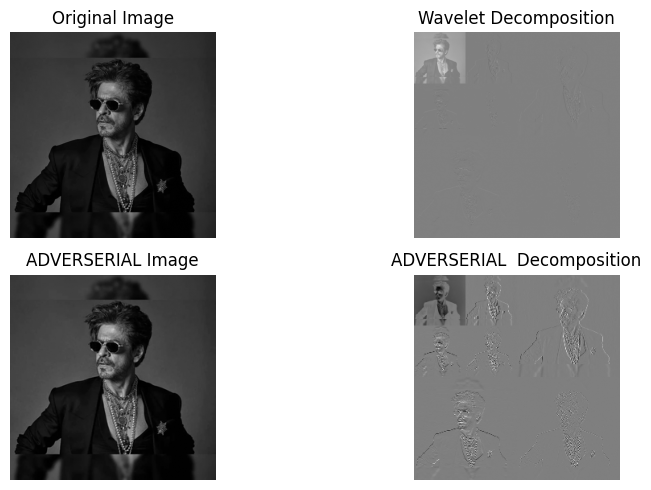

In [12]:
#  Wavelet Decomposition
n=2
w='db1'

coeffs_clean=pywt.wavedec2(B, wavelet=w, level=n)
coeffs_adv=pywt.wavedec2(B_adv, wavelet=w, level=n)
# Normalize each coefficient array
coeffs_clean = [c / np.max(np.abs(c)) for c in coeffs_clean]
coeffs_adv = [c / np.max(np.abs(c)) for c in coeffs_adv]

for i in range(1, len(coeffs_clean)):
    coeffs_clean[i] = [c / np.max(np.abs(c)) for c in coeffs_clean[i]]
    coeffs_adv[i] = [c / np.max(np.abs(c)) for c in coeffs_adv[i]]

arr , coeff_slices = pywt.coeffs_to_array(coeffs_clean)
arr_adv , coeff_slices_adv = pywt.coeffs_to_array(coeffs_adv)

# Ploting
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
axs[0][0].imshow(B,cmap='gray')
axs[0][0].set_title('Original Image')
axs[0][0].axis('off')
axs[0][1].imshow(arr, cmap='gray')
axs[0][1].set_title('Wavelet Decomposition')
axs[0][1].axis('off')
axs[1][0].imshow(B_adv,cmap='gray')
axs[1][0].set_title('ADVERSERIAL Image')
axs[1][0].axis('off')
axs[1][1].imshow(arr_adv, cmap='gray_r')
axs[1][1].set_title('ADVERSERIAL  Decomposition')
axs[1][1].axis('off')
plt.tight_layout()
plt.show()


## Combining loss Functions

In [51]:
# Aegis_Setup_HOG_Wavelet.py
# === Cell 1: Mount Google Drive & Create Project Directory ===
from google.colab import drive
import os

drive.mount('/content/drive')

PROJECT_PATH = "/content/drive/MyDrive/BTech_Aegis_Project_PyTorch" # Explicitly PyTorch
DATA_PATH = os.path.join(PROJECT_PATH, "data")
OUTPUT_PATH = os.path.join(PROJECT_PATH, "output")
os.makedirs(PROJECT_PATH, exist_ok=True); os.makedirs(DATA_PATH, exist_ok=True); os.makedirs(OUTPUT_PATH, exist_ok=True)
print(f"Project directory created at: {PROJECT_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project directory created at: /content/drive/MyDrive/BTech_Aegis_Project_PyTorch


In [2]:
#  1. Upgrade pip, wheel, setuptools for building dependencies
!pip install --upgrade pip setuptools wheel

# 2. Uninstall current numpy
!pip uninstall -y numpy

# 3. Install numpy from wheel only
!pip install numpy==1.26.2 --only-binary=:all:



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 34.1 MB/s  0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.2 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.2 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.2 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.2 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.2 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.2 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.2 which is incompatible.


In [1]:
# 3. Install core vision/ML frameworks
!pip install torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2

# 4. Install face libraries and feature extraction packages
!pip install facenet-pytorch insightface

# 5. Supporting libraries for ArcFace/InsightFace
!pip install onnx==1.17.0 onnxruntime==1.17.0 opencv-python-headless

# 6. Diffusion models & utilities
!pip install diffusers==0.29.0 transformers==4.44.2 accelerate==0.33.0 pillow matplotlib lpips kornia lz4

# 7. HOG features and wavelet analysis
!pip install scikit-image pywt

# 8. (Optional) TensorFlow, IF and ONLY IF you need tf-based code for other tasks (not needed for MTCNN/ArcFace here)
# !pip install tensorflow==2.14.0

print("----------------------------------------------------------------------")
print("!!! PLEASE RESTART COLAB RUNTIME NOW !!!")
print("----------------------------------------------------------------------")


INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
  Using cached opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (50.0 MB)
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 144.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 103.2 MB/s  0:00:00
  Attempting uninstall: onnx
    Found existing installation: onnx 1.19.1
    Uninstalling onnx-1.19.1:
      Successfully uninstalled onnx-1.19.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [onnxruntime]
ERROR: Could not 

In [2]:
# === Cell 3: Import All Necessary Libraries ===
# (Run AFTER restarting runtime)
# --- Core Frameworks & Utils ---
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from google.colab import files
from tqdm.auto import tqdm
import gc
import torchvision
import torchvision.transforms as T
import torchvision.models as models # Keep for potential ResNet comparison later
import lpips # For LPIPS loss

# --- Diffusion Components ---
try:
    from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler
    from diffusers.models.attention_processor import Attention # Keep for L_attn exploration
    from functools import partial
except ImportError as e: print(f"ERROR importing from diffusers: {e}"); raise e

# --- Face Model Libraries & Dependencies ---
print("--- Verifying Library Imports and Versions ---")
print(f"Python Version: {sys.version}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")
print(f"NumPy Version: {np.__version__}")
try: import diffusers; print(f"Diffusers Version: {diffusers.__version__}")
except: print("ERROR: Diffusers failed to import!")
try: import transformers; print(f"Transformers Version: {transformers.__version__}")
except: print("ERROR: Transformers failed to import!")

# --- MTCNN (from facenet-pytorch) ---
print("\n--- Checking FaceNet-PyTorch MTCNN ---")
try:
    from facenet_pytorch import MTCNN # Import the MTCNN class
    # Test initialization - specify device
    mtcnn_check = MTCNN(keep_all=True, device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))
    print("facenet-pytorch MTCNN imported and initialized successfully.")
    del mtcnn_check # Clean up
except ImportError: print("ERROR: Could not import MTCNN from facenet-pytorch.")
except Exception as e: print(f"ERROR initializing facenet-pytorch MTCNN: {e}")

# --- PNet (Keep check for future L_feat) ---
try:
    from facenet_pytorch.models.mtcnn import PNet
    _ = PNet(); print("facenet-pytorch PNet accessible."); del _
except ImportError: print("WARN: Could not import PNet from facenet-pytorch.")
except Exception as e: print(f"WARN: Error accessing/instantiating facenet-pytorch PNet: {e}")

# --- InsightFace & Dependencies (Keep check for future L_id) ---
print("\n--- Checking InsightFace ---")
try:
    import onnxruntime; print(f"ONNX Runtime Version: {onnxruntime.__version__}")
except ImportError: print("WARN: ONNX Runtime failed to import!")
try:
    import cv2; print(f"OpenCV Version: {cv2.__version__}")
except ImportError: print("WARN: OpenCV failed to import!")
try:
    import insightface
    from insightface.app import FaceAnalysis
    # CPU check first
    _ = FaceAnalysis(name='buffalo_l', providers=['CPUExecutionProvider']); print("InsightFace initialized (CPU check)."); del _
except ImportError: print("WARN: insightface failed to import.")
except Exception as e: print(f"WARN: Error initializing InsightFace: {e}")

# --- New Feature Libraries ---
print("\n--- Checking HOG/Wavelet Libraries ---")
try:
    import skimage.feature
    print("scikit-image (for HOG) imported successfully.")
except ImportError: print("ERROR: scikit-image failed to import!")
try:
    import pywt
    print("PyWavelets (pywt) imported successfully.")
except ImportError: print("ERROR: PyWavelets failed to import!")

print("\nCore library import checks complete. Please review any ERROR/WARN messages.")

/usr/local/lib/python3.12/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


--- Verifying Library Imports and Versions ---
Python Version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch Version: 2.2.2+cu121
Torchvision Version: 0.17.2+cu121
NumPy Version: 1.26.2
Diffusers Version: 0.29.0
Transformers Version: 4.44.2

--- Checking FaceNet-PyTorch MTCNN ---
facenet-pytorch MTCNN imported and initialized successfully.
facenet-pytorch PNet accessible.

--- Checking InsightFace ---
ONNX Runtime Version: 1.17.0
OpenCV Version: 4.11.0
download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:03<00:00, 85090.29KB/s]


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
InsightFace initialized (CPU check).


In [3]:
# === Cell 4: Initialize Device ===
# (Sets up PyTorch device)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cpu_device = torch.device('cpu') # Define CPU device for MTCNN if needed
print(f"\nMain PyTorch device set to: {device}")


Main PyTorch device set to: cuda:0


In [37]:
# === Cell 5: Upload Your Test Image ===
from google.colab import files
import os
from PIL import Image # Needed here for basic loading check
# Assume PROJECT_PATH and DATA_PATH are defined from Cell 1
# PROJECT_PATH = "/content/drive/MyDrive/BTech_Aegis_Project_PyTorch" # Example
# DATA_PATH = os.path.join(PROJECT_PATH, "data") # Example

print("\n--- Uploading Image ---")
uploaded = files.upload()

if not uploaded:
    print("ERROR: No file uploaded. Please upload an image to proceed.")
    # Handle error - maybe raise exception or exit
    raise FileNotFoundError("No image uploaded by the user.")
else:
    TEST_IMAGE_NAME = list(uploaded.keys())[0]
    TEST_IMAGE_PATH = os.path.join(DATA_PATH, TEST_IMAGE_NAME)

    # Save the uploaded file to the designated path
    try:
        with open(TEST_IMAGE_PATH, 'wb') as f:
            f.write(uploaded[TEST_IMAGE_NAME])
        print(f"Image '{TEST_IMAGE_NAME}' uploaded and saved to {TEST_IMAGE_PATH}")
        # Optional: Basic check if it's a valid image
        try:
            _ = Image.open(TEST_IMAGE_PATH).convert('RGB')
            print("Image loaded successfully with PIL.")
        except Exception as e:
            print(f"WARNING: Uploaded file might not be a valid image: {e}")
    except Exception as e:
        print(f"ERROR saving uploaded file: {e}")
        raise # Stop execution if saving failed


--- Uploading Image ---


Saving srk.webp to srk.webp
Image 'srk.webp' uploaded and saved to /content/drive/MyDrive/BTech_Aegis_Project_PyTorch/data/srk.webp
Image loaded successfully with PIL.


In [38]:
# === Cell 6: Step 1 - Face Detection using facenet-pytorch MTCNN ===
import numpy as np # Ensure numpy is imported
from facenet_pytorch import MTCNN # Ensure MTCNN is imported
import gc
import torch # For torch.cuda.empty_cache()
import matplotlib.pyplot as plt # For mask visualization
# Assume 'device' is defined from Cell 4

print("\n--- Step 1: Performing face detection using facenet-pytorch MTCNN ---")

# Load the image using PIL
try:
    img_pil_orig = Image.open(TEST_IMAGE_PATH).convert('RGB')
    # MTCNN from facenet-pytorch works directly with PIL images
    print(f"Loaded image for detection (PIL format). Size: {img_pil_orig.size}")
except Exception as e:
    print(f"ERROR loading image for detection: {e}")
    raise # Stop if image cannot be loaded

# Initialize MTCNN detector from facenet-pytorch
# We can specify the device (GPU or CPU)
# keep_all=True finds all faces, not just the best one
try:
    # Use GPU if available, otherwise CPU
    mtcnn_device = device # Use the main PyTorch device
    mtcnn = MTCNN(keep_all=True, device=mtcnn_device)
    print(f"facenet-pytorch MTCNN detector initialized on device: {mtcnn_device}")
except Exception as e:
    print(f"ERROR initializing facenet-pytorch MTCNN: {e}")
    raise RuntimeError(f"MTCNN failed initialization: {e}") from e

# Detect faces
# Returns bounding boxes, probabilities, and landmarks (optional)
print("Detecting faces...")
try:
    # Pass PIL image directly
    boxes, probs, landmarks = mtcnn.detect(img_pil_orig, landmarks=True)
    # Check if boxes is None (no face detected)
    if boxes is None:
        faces_detected = 0
        boxes = [] # Ensure boxes is an empty list if None
    else:
        faces_detected = len(boxes)
except Exception as e:
    print(f"ERROR during face detection: {e}")
    print("Defaulting to full image mask due to detection error.")
    faces_detected = 0
    boxes = []

# Create mask based on detection results
img_np_orig = np.array(img_pil_orig) # Convert PIL to numpy for mask creation
img_h, img_w = img_np_orig.shape[:2]
mask_np = np.zeros((img_h, img_w), dtype=np.uint8) # Initialize mask as all zeros

if faces_detected > 0:
    print(f"Detected {faces_detected} face(s). Creating mask...")
    face_found_and_masked = False
    for i, box in enumerate(boxes):
        # Extract coordinates (x1, y1, x2, y2)
        x1, y1, x2, y2 = map(int, box)
        print(f"  Face {i+1}: Box={box.tolist()}, Prob={probs[i]:.4f}")

        # Add padding (can be adjusted)
        w = x2 - x1
        h = y2 - y1
        padding_w = int(0.1 * w)
        padding_h = int(0.1 * h)
        bx1 = max(0, x1 - padding_w)
        by1 = max(0, y1 - padding_h)
        bx2 = min(img_w - 1, x2 + padding_w)
        by2 = min(img_h - 1, y2 + padding_h)

        # Fill the face region in the mask if coordinates are valid
        if bx1 < bx2 and by1 < by2:
            mask_np[by1:by2, bx1:bx2] = 1
            face_found_and_masked = True
        else:
             print(f"  WARN: Invalid coordinates after padding for face {i+1}.")

    if not face_found_and_masked:
         print("Face(s) detected, but masking failed. Defaulting to full mask.")
         mask_np = np.ones((img_h, img_w), dtype=np.uint8) # Default to full mask
    else:
         print("Successfully created mask from detected face(s).")
else:
    print("No faces detected by facenet-pytorch MTCNN. Defaulting to full image mask.")
    mask_np = np.ones((img_h, img_w), dtype=np.uint8) # Default to full mask

# Clean up MTCNN object
if 'mtcnn' in locals():
    del mtcnn
    print("MTCNN detector object deleted.")
gc.collect()
if torch.cuda.is_available(): # Only clear cache if CUDA is used
    torch.cuda.empty_cache()

print("\nFace detection and masking complete using facenet-pytorch MTCNN.")
# Optional: Display the original size mask
# plt.figure(figsize=(6,6)); plt.imshow(mask_np, cmap='gray');
# plt.title("Generated Mask (Original Size - facenet MTCNN)"); plt.axis('off'); plt.show()


--- Step 1: Performing face detection using facenet-pytorch MTCNN ---
Loaded image for detection (PIL format). Size: (1200, 1200)
facenet-pytorch MTCNN detector initialized on device: cuda:0
Detecting faces...
Detected 1 face(s). Creating mask...
  Face 1: Box=[501.3331298828125, 282.5341796875, 717.2582397460938, 590.3150634765625], Prob=1.0000
Successfully created mask from detected face(s).
MTCNN detector object deleted.

Face detection and masking complete using facenet-pytorch MTCNN.


--- Setting up Tensors (Resolution: 256x256) ---
Resizing image and mask to 256x256...
Resizing complete.
Image, Mask (MTCNN FACE ONLY?), Delta tensors created on cuda:0.
  Image shape: torch.Size([1, 3, 256, 256]), Mask shape: torch.Size([1, 1, 256, 256]), Delta shape: torch.Size([1, 3, 256, 256])
  Mask tensor sum (check if mask is correct): 4290.0


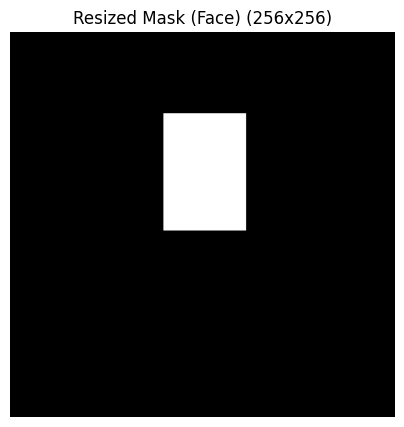

CLIP preprocess defined (Requires input size 224x224).
P-Net preprocess defined (Normalize to [-1, 1]).
InsightFace preprocessing is complex, typically handled by its .get() method.

Helper functions and tensor setup complete.


In [39]:
# === Cell 7: Helper Functions & Tensor Setup (256x256) ===
import torch
import torchvision.transforms as T
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
# Assume 'device' is defined from Cell 4
# Assume 'mask_np' and 'img_pil_orig' are available from Cell 6

RESOLUTION = 256 # Define the working resolution
print(f"--- Setting up Tensors (Resolution: {RESOLUTION}x{RESOLUTION}) ---")

# --- Helper Functions ---
def to_tensor(img_array):
    """ Converts HWC uint8 [0,255] numpy array to CHW float32 [0,1] tensor on device. """
    img_tensor = torch.from_numpy(img_array).float() / 255.0
    img_tensor = img_tensor.permute(2, 0, 1) # HWC to CHW
    return img_tensor.to(device)

def to_numpy(img_tensor):
    """ Converts BCHW or CHW float tensor [0,1] to HWC uint8 [0,255] numpy array on CPU. """
    if img_tensor.dtype != torch.float32:
        img_tensor = img_tensor.float() # Convert from float16 if necessary
    if img_tensor.dim() == 4:
        img_tensor = img_tensor[0] # Remove batch dim
    # Move tensor to CPU before converting to numpy
    img_np = img_tensor.permute(1, 2, 0).clamp(0, 1).mul(255).byte().cpu().numpy() # CHW to HWC
    return img_np

def tensor_to_pil(img_tensor):
    """ Converts BCHW or CHW float tensor [0,1] to PIL Image. """
    return Image.fromarray(to_numpy(img_tensor))

# --- Resize Image and Mask ---
print(f"Resizing image and mask to {RESOLUTION}x{RESOLUTION}...")
try:
    img_pil_resized = img_pil_orig.resize((RESOLUTION, RESOLUTION), Image.LANCZOS) # Use high-quality resize for image
    # Ensure mask_np exists before resizing
    if 'mask_np' not in locals() or mask_np is None:
         print("ERROR: mask_np not found from Cell 6. Using default full mask.")
         mask_np_resized = np.ones((RESOLUTION, RESOLUTION), dtype=np.uint8) # Default full mask
    else:
         mask_pil_resized = Image.fromarray(mask_np).resize((RESOLUTION, RESOLUTION), Image.NEAREST) # Use nearest for binary mask
         mask_np_resized = np.array(mask_pil_resized)

    img_np_resized = np.array(img_pil_resized)
    print("Resizing complete.")
except Exception as e:
    print(f"ERROR during resizing: {e}")
    raise # Stop if resizing fails

# --- Convert to PyTorch Tensors ---
dtype_attack = torch.float32 # Use float32 for stability, hooks, gradients
try:
    # Image tensor: Add batch dim -> [1, 3, H, W], range [0, 1]
    image_tensor = to_tensor(img_np_resized).unsqueeze(0).to(dtype_attack)

    # Mask tensor: Add batch and channel dims -> [1, 1, H, W], range [0, 1]
    mask_tensor = torch.from_numpy(mask_np_resized).float().unsqueeze(0).unsqueeze(0).to(device).to(dtype_attack)

    # Delta tensor (perturbation): Initialize with small random noise, requires grad
    # Range [-0.001, 0.001] initially
    delta = (torch.rand_like(image_tensor) * 2 - 1) * 0.001
    delta = delta.to(dtype_attack)
    delta.requires_grad_(True) # CRITICAL: Ensure gradients are tracked for delta

    print(f"Image, Mask (MTCNN FACE ONLY?), Delta tensors created on {device}.")
    print(f"  Image shape: {image_tensor.shape}, Mask shape: {mask_tensor.shape}, Delta shape: {delta.shape}")
    print(f"  Mask tensor sum (check if mask is correct): {mask_tensor.sum().item()}")

    # Visualize the resized mask to confirm
    plt.figure(figsize=(5,5))
    plt.imshow(mask_np_resized, cmap='gray')
    plt.title(f"Resized Mask ({'Face' if mask_np.sum()>0 and mask_np.mean()<1 else 'Full'}) ({RESOLUTION}x{RESOLUTION})")
    plt.axis('off')
    plt.show()

except Exception as e:
    print(f"ERROR creating tensors: {e}")
    raise

# --- Normalization/Denormalization Functions ---
def normalize_neg1_pos1(img_tensor):
    """ Normalizes image tensor from [0, 1] to [-1, 1]. """
    return img_tensor * 2.0 - 1.0

def denormalize_0_1(img_tensor):
     """ Denormalizes image tensor from [-1, 1] back to [0, 1]. """
     return (img_tensor + 1.0) / 2.0

# --- Preprocessing Transforms for Specific Models ---

# Preprocessing for CLIP Vision Model (if used for L_proj)
# Input tensor expected: BCHW [0, 1]
clip_preprocess = T.Compose([
    # T.Resize(224, interpolation=T.InterpolationMode.BICUBIC), # Resize handled later if needed
    # T.CenterCrop(224),
    T.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711]),
])
print("CLIP preprocess defined (Requires input size 224x224).")


# Preprocessing for MTCNN P-Net (if used for L_feat)
# P-Net from facenet-pytorch expects input normalized to [-1, 1]
# It handles resizing internally. Input tensor expected: BCHW [0, 1]
pnet_preprocess = T.Compose([
     T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Simple [-1, 1] normalization
])
print("P-Net preprocess defined (Normalize to [-1, 1]).")

# Preprocessing for InsightFace ArcFace model (if used for L_id)
# Input: PIL Image or HWC Numpy array
# Output: Needs alignment, resizing to 112x112, BGR conversion, specific normalization
# This is complex and best handled by the insightface .get() method if possible,
# otherwise requires manual implementation using landmarks if calculating gradients.
print("InsightFace preprocessing is complex, typically handled by its .get() method.")

print("\nHelper functions and tensor setup complete.")

In [40]:
# === New Cell (Run BEFORE loading models): Hugging Face Login ===
from huggingface_hub import login
import os
from google.colab import userdata # Use Colab secrets for token

# Option 1: Using Colab Secrets (Recommended)
# 1. Click the "Key" icon on the left sidebar in Colab.
# 2. Add a new secret named "HF_TOKEN".
# 3. Paste your Hugging Face access token as the value.
# 4. Make sure "Notebook access" is toggled ON.
try:
    hf_token = userdata.get('HF_TOKEN')
    print("Attempting Hugging Face login using token from Colab Secrets...")
    login(token=hf_token)
    print("Login successful (using Colab Secrets token).")
except userdata.SecretNotFoundError:
    print("HF_TOKEN secret not found.")
    print("Please add your Hugging Face token to Colab Secrets (Key icon -> Add new secret).")
    # Option 2: Paste token directly (Less Secure!) - Uncomment below if needed
    # hf_token_direct = "YOUR_HF_TOKEN_HERE" # PASTE YOUR TOKEN
    # print("Attempting Hugging Face login using direct token (less secure)...")
    # if hf_token_direct != "YOUR_HF_TOKEN_HERE":
    #    login(token=hf_token_direct)
    #    print("Login successful (using direct token).")
    # else:
    #    print("Please paste your token directly in the code (less secure) or use Colab Secrets.")
    #    raise ValueError("Hugging Face token not provided.")
except Exception as e:
    print(f"An error occurred during Hugging Face login: {e}")
    raise

# Verify login status (optional)
from huggingface_hub import whoami
try:
  user_info = whoami()
  print(f"Logged in as: {user_info.get('name')}")
except Exception as e:
  print(f"Could not verify login status: {e}")

Attempting Hugging Face login using token from Colab Secrets...
Login successful (using Colab Secrets token).
Logged in as: arif-hussain09


In [41]:


# Aegis_Load_Models_Corrected.py
# === Cell 1-7: Setup, Installs (Restarted), Imports, Device, Upload, Face Detect, Helpers ===
# (Assumed already run successfully)
# ...
# Assume 'device', 'dtype_attack', 'image_tensor', 'to_numpy', 'normalize', 'denormalize',
#        'clip_preprocess', 'pnet_preprocess', 'scaling_factor' (default or VAE config) are defined

# === Cell 8: Load All Models for FaceShield Losses (CORRECTED) ===
import torch
import torch.nn as nn
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler
from transformers import CLIPVisionModelWithProjection
# Ensure PNet is importable after restart
try:
    from facenet_pytorch.models.mtcnn import PNet
    PNet_available = True
except ImportError:
    PNet_available = False
    print("WARN: facenet-pytorch PNet not importable.")
# Ensure InsightFace is importable after restart
try:
    import insightface
    from insightface.app import FaceAnalysis
    import cv2 # Needed for InsightFace preprocessing
    InsightFace_available = True
except ImportError:
    InsightFace_available = False
    print("WARN: insightface or opencv not importable.")
import lpips
import gc

# --- Define Model IDs ---
MODEL_ID_SD = "runwayml/stable-diffusion-v1-5" # CORRECT: Use the string ID
MODEL_ID_CLIP = "openai/clip-vit-large-patch14"

# --- Define dtype from previous cell ---
# dtype_attack = torch.float32 # Example, should be defined in Cell 7

print("\n--- Loading Required Models ---")

# --- Initialize model variables ---
vae = None
unet = None
scheduler = None
lpips_loss_fn = None
clip_vision_model = None
pnet_feature_extractor = None
face_app = None
f_clean_arcface = None
# Define scaling_factor here or ensure it's loaded from VAE config later
scaling_factor = 0.18215 # Default for SD v1.x VAEs

# --- Load VAE ---
print(f"Loading VAE ({MODEL_ID_SD})... (to {device}, {dtype_attack})")
try:
    # CORRECT: Use the string ID
    vae = AutoencoderKL.from_pretrained(MODEL_ID_SD, subfolder="vae", torch_dtype=dtype_attack).to(device)
    vae.requires_grad_(False); vae.eval()
    try:
        scaling_factor = vae.config.scaling_factor # Get actual scaling factor
    except AttributeError:
        print("Using default VAE scaling factor.")
    print(f"VAE loaded successfully. Scaling factor: {scaling_factor}")
except Exception as e:
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print(f"ERROR loading VAE: {e}")
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

# --- Load U-Net ---
print(f"\nLoading U-Net ({MODEL_ID_SD})... (to {device}, {dtype_attack})")
try:
    # CORRECT: Use the string ID
    unet = UNet2DConditionModel.from_pretrained(MODEL_ID_SD, subfolder="unet", torch_dtype=dtype_attack).to(device)
    unet.requires_grad_(False); unet.eval()
    unet.enable_gradient_checkpointing() # Enable checkpointing AFTER loading
    print("U-Net loaded & Gradient Checkpointing Enabled.")
except Exception as e:
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print(f"ERROR loading U-Net: {e}")
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

# --- Load Scheduler ---
print(f"\nLoading Scheduler ({MODEL_ID_SD})...")
try:
    # CORRECT: Use the string ID
    scheduler = DDPMScheduler.from_pretrained(MODEL_ID_SD, subfolder="scheduler")
    print("Scheduler loaded successfully.")
except Exception as e:
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print(f"ERROR loading Scheduler: {e}")
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

# --- Load LPIPS ---
print(f"\nLoading LPIPS model... (to {device})")
try:
    if 'lpips' in locals() and lpips is not None:
        lpips_loss_fn = lpips.LPIPS(net='alex').to(device)
        lpips_loss_fn.requires_grad_(False); lpips_loss_fn.eval()
        print("LPIPS model loaded successfully.")
    else:
        print("WARN: LPIPS library not imported, cannot load model.")
except Exception as e:
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print(f"ERROR loading LPIPS model: {e}")
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

# --- Load CLIP Vision Projector ---
print(f"\nLoading CLIP Vision Projector ({MODEL_ID_CLIP})... (to {device})")
try:
    if 'CLIPVisionModelWithProjection' in locals():
         clip_vision_model = CLIPVisionModelWithProjection.from_pretrained(MODEL_ID_CLIP, torch_dtype=dtype_attack).to(device)
         clip_vision_model.requires_grad_(False); clip_vision_model.eval()
         print("CLIP Vision Projector loaded successfully.")
    else:
         print("WARN: CLIPVisionModelWithProjection not imported. L_proj disabled.")
except Exception as e:
    print(f"WARN: Failed to load CLIP model: {e}. L_proj will be disabled.")

# --- Load MTCNN P-Net for L_feat ---
print("\nLoading MTCNN P-Net (from facenet-pytorch)... (to {device})")
try:
    if PNet_available: # Check if import worked in Cell 3
        pnet_feature_extractor = PNet(pretrained=True).to(device)
        pnet_feature_extractor.eval().requires_grad_(False)
        print("Loaded facenet-pytorch PNet for L_feat successfully.")
    else:
        print("WARN: PNet not importable (check Cell 3). L_mtcnn disabled.")
except Exception as e:
    print(f"WARN: Failed to load facenet-pytorch PNet: {e}. L_mtcnn will be disabled.")

# --- Load ArcFace for L_id (via InsightFace) ---
print("\nLoading InsightFace Model (ArcFace)... (Trying GPU first)")
try:
    if InsightFace_available: # Check if import worked in Cell 3
        providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']
        face_app = FaceAnalysis(name='buffalo_l', providers=providers)
        face_app.prepare(ctx_id=0, det_size=(640, 640)) # ctx_id=0 for GPU 0
        print("InsightFace FaceAnalysis app loaded (GPU preferred).")

        # Pre-calculate clean ArcFace feature
        print("Calculating clean ArcFace feature...")
        with torch.no_grad():
            # Ensure helper `to_numpy` is defined and works
            clean_np_uint8 = to_numpy(image_tensor) # Function from Cell 7
            clean_np_bgr = cv2.cvtColor(clean_np_uint8, cv2.COLOR_RGB2BGR)
            faces_clean_arc = face_app.get(clean_np_bgr) # Run inference
            if faces_clean_arc and len(faces_clean_arc) > 0:
                f_clean_arcface_np = faces_clean_arc[0].normed_embedding
                f_clean_arcface = torch.tensor(f_clean_arcface_np).unsqueeze(0).to(device).to(dtype_attack) # Match dtype
                print(f"Calculated clean ArcFace features (shape: {f_clean_arcface.shape}).")
            else:
                print("WARN: No face detected in clean image by InsightFace. L_id will be disabled.")
                face_app = None # Disable loss if no face found
    else:
        print("WARN: Insightface or OpenCV not importable (check Cell 3). L_id disabled.")

except Exception as e:
    print(f"WARN: Error loading/using InsightFace: {e}.")
    print("   L_id will be disabled.")
    face_app = None # Ensure disabled on error

# --- Null Prompt ---
null_prompt = torch.zeros(1, 77, 768, device=device, dtype=dtype_attack)
print("\nNull prompt tensor created.")

# --- Final Check ---
print("\n--- Model Loading Summary ---")
core_models_loaded = True
if vae is None: print("ERROR: VAE failed to load."); core_models_loaded = False
else: print("VAE loaded OK.")
if unet is None: print("ERROR: U-Net failed to load."); core_models_loaded = False
else: print("U-Net loaded OK.")
if scheduler is None: print("ERROR: Scheduler failed to load."); core_models_loaded = False
else: print("Scheduler loaded OK.")

if not core_models_loaded:
     raise RuntimeError("One or more core VAE/U-Net/Scheduler components failed to load. Cannot proceed.")

# Report on optional models
if lpips_loss_fn is None: print("WARN: LPIPS loss is disabled.")
else: print("LPIPS model loaded OK.")
if clip_vision_model is None: print("WARN: L_proj loss is disabled.")
else: print("CLIP Vision model loaded OK.")
if pnet_feature_extractor is None: print("WARN: L_mtcnn (PNet) loss is disabled.")
else: print("PNet model loaded OK.")
if face_app is None or f_clean_arcface is None: print("WARN: L_id (ArcFace) loss is disabled.")
else: print("InsightFace model loaded OK.")

print("\nModel loading phase complete. Review ERROR messages and WARNings above.")


--- Loading Required Models ---
Loading VAE (runwayml/stable-diffusion-v1-5)... (to cuda:0, torch.float32)
VAE loaded successfully. Scaling factor: 0.18215

Loading U-Net (runwayml/stable-diffusion-v1-5)... (to cuda:0, torch.float32)
U-Net loaded & Gradient Checkpointing Enabled.

Loading Scheduler (runwayml/stable-diffusion-v1-5)...
Scheduler loaded successfully.

Loading LPIPS model... (to cuda:0)
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
LPIPS model loaded successfully.

Loading CLIP Vision Projector (openai/clip-vit-large-patch14)... (to cuda:0)
CLIP Vision Projector loaded successfully.

Loading MTCNN P-Net (from facenet-pytorch)... (to {device})
Loaded facenet-pytorch PNet for L_feat successfully.

Loading InsightFace Model (ArcFace)... (Trying GPU first)


/usr/local/lib/python3.12/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
InsightFace 

/usr/local/lib/python3.12/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


Calculated clean ArcFace features (shape: torch.Size([1, 512])).

Null prompt tensor created.

--- Model Loading Summary ---
VAE loaded OK.
U-Net loaded OK.
Scheduler loaded OK.
LPIPS model loaded OK.
CLIP Vision model loaded OK.
PNet model loaded OK.
InsightFace model loaded OK.

Model loading phase complete. Review ERROR messages and WARNings above.


In [42]:
from skimage.feature import hog
# === Cell 9: Define Abstracted Loss Functions ===
print("\n--- Defining Loss Functions ---")

# --- LPIPS Loss ---
def calculate_lpips_loss(img_perturbed_01, img_clean_01, model):
    if model is None: return torch.tensor(0.0, device=img_perturbed_01.device)
    # LPIPS expects BCHW [0, 1], model internally normalizes to [-1, 1]
    loss = model(img_perturbed_01, img_clean_01)
    return loss.mean() # Return scalar

# --- VAE Latent Loss ---
def calculate_vae_loss(img_perturbed_01, z_clean_target, model, scale_factor):
    if model is None: return torch.tensor(0.0, device=img_perturbed_01.device)
    img_norm_neg1_pos1 = normalize_neg1_pos1(img_perturbed_01)
    z_poisoned = model.encode(img_norm_neg1_pos1).latent_dist.mode() * scale_factor
    loss = -F.mse_loss(z_poisoned, z_clean_target) # Maximize distance
    return loss

# --- U-Net Noise Prediction Loss ---
def calculate_unet_loss(img_perturbed_01, timestep, vae_model, unet_model, scheduler_obj, null_prompt_embed, scale_factor):
    if unet_model is None or vae_model is None: return torch.tensor(0.0, device=img_perturbed_01.device)
    # Need latent of perturbed image (requires grad)
    z_poisoned = vae_model.encode(normalize_neg1_pos1(img_perturbed_01)).latent_dist.mode() * scale_factor
    noise = torch.randn_like(z_poisoned)
    noisy_z_poisoned = scheduler_obj.add_noise(z_poisoned, noise, timestep)
    noise_pred = unet_model(noisy_z_poisoned, timestep, encoder_hidden_states=null_prompt_embed).sample
    loss = -F.mse_loss(noise_pred, noise) # Maximize error
    return loss

# --- P-Net Feature Loss (Attempt) ---
# NOTE: Gradients likely won't flow through standard PNet.forward()
def calculate_pnet_loss(img_perturbed_01, pnet_model, clean_pnet_features_target, t_prob=0.9):
    if pnet_model is None or clean_pnet_features_target is None:
         return torch.tensor(0.0, device=img_perturbed_01.device)
    try:
        # PNet expects BCHW [-1, 1]
        pnet_input = normalize_neg1_pos1(img_perturbed_01)
        # Output: tuple (box_probs, box_regs, landmarks(None for PNet))
        pnet_outputs = pnet_model(pnet_input)
        prob_map_poisoned = pnet_outputs[0] # Get Box Probs (is face)

        # Simple Goal: Minimize face probability (maximize distance from clean features)
        # Using Cosine Sim as a proxy for feature distance, similar to FaceShield L_feat
        # Ensure clean_pnet_features_target is the prob map
        loss = F.cosine_similarity(prob_map_poisoned.reshape(1,-1), clean_pnet_features_target.reshape(1,-1)).mean() # Minimize Similarity
        # Return negative similarity if goal is maximization (like other losses)
        # return -loss # Maximize distance
        return loss # Minimize similarity
    except Exception as e:
        print(f"WARN: PNet loss calculation failed: {e}")
        return torch.tensor(0.0, device=img_perturbed_01.device)

# --- ArcFace ID Loss (Monitoring Only) ---
# Returns CosSim - 1 (always <= 0)
def calculate_id_loss_monitor(img_perturbed_01, insightface_app_model, clean_arcface_features_target):
    loss_id_val = torch.tensor(-1.0) # Default if fail (max dissimilarity)
    if insightface_app_model is not None and clean_arcface_features_target is not None:
        try:
            with torch.no_grad(): # No gradients
                perturbed_np_bgr = cv2.cvtColor(to_numpy(img_perturbed_01), cv2.COLOR_RGB2BGR)
                faces_poisoned = insightface_app_model.get(perturbed_np_bgr)
                if faces_poisoned and len(faces_poisoned) > 0:
                    f_poisoned_np = faces_poisoned[0].normed_embedding
                    f_poisoned = torch.tensor(f_poisoned_np).unsqueeze(0).to(device).to(dtype_attack)
                    # Algo 1: Lid = CosSim - 1. Lower is better attack.
                    loss_id_val = F.cosine_similarity(f_poisoned, clean_arcface_features_target).mean() - 1.0
        except Exception as e:
            print(f"WARN: ArcFace inference failed during monitoring: {e}")
    return loss_id_val.item() # Return scalar value

# --- HOG Feature Loss (Attempt - No Grad Expected) ---
# Returns MSE distance (always >= 0)
def calculate_hog_loss_monitor(img_perturbed_01, clean_hog_features_target):
    loss_hog_val = torch.tensor(0.0)
    if clean_hog_features_target is None: return loss_hog_val.item()
    try:
        with torch.no_grad():
            # Convert to grayscale numpy HWC [0, 255]
            img_gray_np = cv2.cvtColor(to_numpy(img_perturbed_01), cv2.COLOR_RGB2GRAY)
            # Calculate HOG features
            # Parameters need tuning: orientations, pixels_per_cell, cells_per_block
            hog_features = hog(img_gray_np, orientations=9, pixels_per_cell=(8, 8),
                               cells_per_block=(2, 2), visualize=False, feature_vector=True)
            hog_features_tensor = torch.tensor(hog_features, device=device, dtype=dtype_attack)
            # Calculate MSE loss (Minimize this means matching features)
            # We want to MAXIMIZE distance, so return negative MSE? No, return MSE for monitoring.
            loss_hog_val = F.mse_loss(hog_features_tensor, clean_hog_features_target)
    except Exception as e:
        print(f"WARN: HOG calculation failed during monitoring: {e}")
    return loss_hog_val.item() # Return scalar value


# --- Wavelet Loss (Attempt - No Grad Expected) ---
# Returns MSE distance (always >= 0)
def calculate_wavelet_loss_monitor(img_perturbed_01, clean_wavelet_coeffs_target, wavelet_name='db1', level=1):
    loss_wavelet_val = torch.tensor(0.0)
    if clean_wavelet_coeffs_target is None: return loss_wavelet_val.item()
    try:
        with torch.no_grad():
            # Convert to grayscale numpy HWC [0, 255] -> HW [0, 255]
            img_gray_np = cv2.cvtColor(to_numpy(img_perturbed_01), cv2.COLOR_RGB2GRAY)
            # Perform DWT
            coeffs = pywt.dwt2(img_gray_np, wavelet_name, mode='symmetric')
            LL, (LH, HL, HH) = coeffs # Approx, Horizontal, Vertical, Diagonal details

            # Concatenate coeffs (simple approach, might compare levels separately)
            # Need to ensure dimensions match clean_wavelet_coeffs_target
            # This part needs careful design based on how clean_coeffs were stored
            coeffs_flat = np.concatenate([LL.ravel(), LH.ravel(), HL.ravel(), HH.ravel()])
            coeffs_tensor = torch.tensor(coeffs_flat, device=device, dtype=dtype_attack)

            # Calculate MSE loss (Minimize this means matching coeffs)
            # We want to MAXIMIZE distance, return MSE for monitoring.
            loss_wavelet_val = F.mse_loss(coeffs_tensor, clean_wavelet_coeffs_target)
    except Exception as e:
        print(f"WARN: Wavelet calculation failed during monitoring: {e}")
    return loss_wavelet_val.item() # Return scalar value


print("Loss function definitions complete.")


--- Defining Loss Functions ---
Loss function definitions complete.


In [43]:
# === Cell 10: Precompute Clean Features/Latents ===
print("\n--- Precomputing Clean Features/Targets ---")
f_clean_pnet_map = None # PNet output (e.g., prob map)
f_clean_arcface = None # InsightFace embedding
f_clean_hog = None # HOG feature vector
f_clean_wavelet = None # Wavelet coefficients
z_clean_flat = None # VAE latent

with torch.no_grad():
    # VAE Latent
    if vae:
        clean_img_norm_vae = normalize_neg1_pos1(image_tensor)
        z_clean = vae.encode(clean_img_norm_vae).latent_dist.mode() * scaling_factor
        z_clean_flat = z_clean.view(z_clean.size(0), -1)
        print(f"Clean VAE latent calculated (shape: {z_clean_flat.shape}).")

    # PNet Features (use prob map as feature proxy)
    if pnet_feature_extractor:
        try:
            pnet_input_clean = normalize_neg1_pos1(image_tensor)
            pnet_outputs_clean = pnet_feature_extractor(pnet_input_clean)
            if isinstance(pnet_outputs_clean, tuple): f_clean_pnet_map = pnet_outputs_clean[0]
            else: f_clean_pnet_map = pnet_outputs_clean
            print(f"Clean PNet features calculated (shape: {f_clean_pnet_map.shape}).")
        except Exception as e: print(f"WARN: Failed to get clean PNet features: {e}")

    # ArcFace Features (already done during InsightFace loading in Cell 8)
    if face_app and 'f_clean_arcface' in locals() and f_clean_arcface is not None:
         print(f"Clean ArcFace features available (shape: {f_clean_arcface.shape}).")
    else: print("Clean ArcFace features unavailable.")

    # HOG Features
    try:
        clean_gray_np = cv2.cvtColor(to_numpy(image_tensor), cv2.COLOR_RGB2GRAY)
        f_clean_hog_np = hog(clean_gray_np, orientations=9, pixels_per_cell=(8, 8),
                             cells_per_block=(2, 2), visualize=False, feature_vector=True)
        f_clean_hog = torch.tensor(f_clean_hog_np, device=device, dtype=dtype_attack)
        print(f"Clean HOG features calculated (shape: {f_clean_hog.shape}).")
    except Exception as e: print(f"WARN: Failed to calculate clean HOG features: {e}")

    # Wavelet Coefficients
    try:
        clean_gray_np_wv = cv2.cvtColor(to_numpy(image_tensor), cv2.COLOR_RGB2GRAY)
        wv_coeffs = pywt.dwt2(clean_gray_np_wv, 'db1', mode='symmetric')
        wv_LL, (wv_LH, wv_HL, wv_HH) = wv_coeffs
        # Store flattened coeffs for comparison
        # Ensure consistent shape for later comparison
        f_clean_wavelet_np = np.concatenate([wv_LL.ravel(), wv_LH.ravel(), wv_HL.ravel(), wv_HH.ravel()])
        f_clean_wavelet = torch.tensor(f_clean_wavelet_np, device=device, dtype=dtype_attack)
        print(f"Clean Wavelet coeffs calculated (shape: {f_clean_wavelet.shape}).")
    except Exception as e: print(f"WARN: Failed to calculate clean Wavelet coeffs: {e}")

print("Precomputation complete.")


--- Precomputing Clean Features/Targets ---
Clean VAE latent calculated (shape: torch.Size([1, 4096])).
Clean PNet features calculated (shape: torch.Size([1, 4, 123, 123])).
Clean ArcFace features unavailable.
Clean HOG features calculated (shape: torch.Size([34596])).
Clean Wavelet coeffs calculated (shape: torch.Size([65536])).
Precomputation complete.


In [47]:
# === Cell 11: Optimization Loop (Abstracted Losses, Single Backward) ===
print("\n--- Starting Optimization Loop ---")
# --- Hyperparameters ---
LEARNING_RATE = 0.005
NUM_STEPS = 500
EPSILON = 0.021
# --- Loss Weights (Set non-zero only for desired + available components) ---
W_VAE = 1.0 if vae else 0.0
W_LPIPS = 1.1 if lpips_loss_fn else 0.0
W_UNET = 1.0 if unet else 0.0
W_PNET = 0.8 if pnet_feature_extractor and f_clean_pnet_map is not None else 0.0 # Weight for PNet (if used for grad)
W_ID = 0.8 # Set to 0.0 since we only monitor
W_HOG = 0.5 # Set to 0.0 since likely no grad
W_WAVELET = 0.5 # Set to 0.0 since likely no grad
BLUR_PROB = 0.3
LOG_INTERVAL = 20

optimizer = torch.optim.Adam([delta], lr=LEARNING_RATE)
gaussian_blur = T.GaussianBlur(kernel_size=5, sigma=(0.1, 1.5))

# --- Tracking Lists ---
tracked_steps = []; tracked_total_loss = [] # Track combined loss if possible
tracked_lpips_loss = []; tracked_vae_loss = []; tracked_unet_loss = []
tracked_pnet_loss = []; tracked_id_loss = []; tracked_hog_loss = []; tracked_wavelet_loss = []

pbar = tqdm(range(NUM_STEPS))

# --- Optimization Loop ---
for step in pbar:
    optimizer.zero_grad()
    delta.requires_grad_(True) # Make sure grad is enabled for delta

    perturbed_image = torch.clamp(image_tensor + (delta * mask_tensor), 0, 1) # [0,1]

    # Augmentation
    augmented_perturbed = perturbed_image.clone()
    if torch.rand(1).item() < BLUR_PROB:
        augmented_perturbed = gaussian_blur(augmented_perturbed)

    # --- Calculate Individual Losses using Functions ---
    # Differentiable losses first
    loss_lpips_val = calculate_lpips_loss(augmented_perturbed, image_tensor, lpips_loss_fn)
    loss_vae_val = calculate_vae_loss(augmented_perturbed, z_clean, vae, scaling_factor)
    t_unet = torch.randint(200, 800, (1,)).long().to(device) # Sample timestep here
    loss_unet_val = calculate_unet_loss(augmented_perturbed, t_unet, vae, unet, scheduler, null_prompt, scaling_factor)
    loss_pnet_val = calculate_pnet_loss(augmented_perturbed, pnet_feature_extractor, f_clean_pnet_map) # Might not have grad

    # Monitoring losses (no grad expected)
    loss_id_val = calculate_id_loss_monitor(augmented_perturbed, face_app, f_clean_arcface)
    loss_hog_val = calculate_hog_loss_monitor(augmented_perturbed, f_clean_hog)
    loss_wavelet_val = calculate_wavelet_loss_monitor(augmented_perturbed, f_clean_wavelet)

    # --- Combine Losses (with weights and signs for maximization/minimization) ---
    # Minimize LPIPS
    # Maximize VAE distance (minimize -MSE) -> use loss_vae_val directly
    # Maximize UNET error (minimize -MSE) -> use loss_unet_val directly
    # Maximize PNet distance (minimize Similarity) -> use loss_pnet_val if it's Similarity
    # Maximize ID distance (minimize CosSim-1) -> use W_ID * (loss_id_val) if loss_id_val is CosSim-1 (MONITOR ONLY)
    # Maximize HOG distance (minimize -MSE) -> Use -W_HOG * loss_hog_val if loss_hog_val is MSE (MONITOR ONLY)
    # Maximize Wavelet distance (minimize -MSE) -> Use -W_WAVELET * loss_wavelet_val if loss_wavelet_val is MSE (MONITOR ONLY)

    total_loss = (W_LPIPS * loss_lpips_val) + \
                 (W_VAE * loss_vae_val) + \
                 (W_UNET * loss_unet_val) + \
                 (W_PNET * loss_pnet_val) # Assumes pnet_loss is sim, minimizing maximizes dist
                 # Add other terms here if they become differentiable

    # --- Backward Pass & Optimizer Step ---
    try:
        total_loss.backward() # Single backward call
        optimizer.step()      # Update delta
    except RuntimeError as e:
         print(f"\nERROR during backward/step at step {step}: {e}")
         print("This might be due to VRAM limits or non-differentiable ops.")
         # Option: Break the loop or try recovery (e.g., skip step)
         break # Stop optimization on error

    # --- PGD Projection ---
    with torch.no_grad():
        delta.data = torch.clamp(delta.data, -EPSILON, EPSILON)
        delta.data *= mask_tensor

    # --- Log Metrics ---
    if step % LOG_INTERVAL == 0 or step == NUM_STEPS - 1:
        tracked_steps.append(step)
        tracked_total_loss.append(total_loss.item()) # Log combined loss value
        tracked_lpips_loss.append(loss_lpips_val.item())
        tracked_vae_loss.append(loss_vae_val.item())
        tracked_unet_loss.append(loss_unet_val.item())
        tracked_pnet_loss.append(loss_pnet_val.item())
        tracked_id_loss.append(loss_id_val) # Log scalar monitor value
        tracked_hog_loss.append(loss_hog_val) # Log scalar monitor value
        tracked_wavelet_loss.append(loss_wavelet_val) # Log scalar monitor value

        # Optional: Recalculate distances for cleaner logging
        with torch.no_grad():
             # ... distance calculations ...
             pnet_dist_log = 1.0 - (loss_pnet_val.item() / W_PNET if W_PNET > 0 else 0.0) # Approx if loss is sim
             id_dist_log = 1.0 - (loss_id_val + 1.0) # Approx
             pbar.set_description(f"S{step} Lpip:{loss_lpips_val.item():.3f} VAE:{loss_vae_val.item():.2f} Unet:{loss_unet_val.item():.2f} PNetD:{pnet_dist_log:.2f} ID_D:{id_dist_log:.2f}")

    # Aggressive cleanup
    del perturbed_image, augmented_perturbed, loss_lpips_val, loss_vae_val, loss_unet_val, loss_pnet_val, total_loss
    if device.type == 'cuda': torch.cuda.empty_cache(); gc.collect()


print("Optimization complete.")
delta_final = delta.detach()


--- Starting Optimization Loop ---


  0%|          | 0/500 [00:00<?, ?it/s]

Optimization complete.


In [48]:
# === Cell 12: Final Analysis & Visualization ===
# (No changes needed here, plotting uses the tracked lists)
# ... (identical to previous version) ...
print("\n--- Final Analysis & Visualization ---")
final_lpips = 0; final_vae_loss = 0; final_pnet_loss = 0
final_id_loss = -1; final_hog_loss = 0; final_wavelet_loss = 0
with torch.no_grad():
    protected_image_final = torch.clamp(image_tensor + (delta_final * mask_tensor), 0, 1)
    if lpips_loss_fn: final_lpips = calculate_lpips_loss(protected_image_final, image_tensor, lpips_loss_fn).item()
    if vae: final_vae_loss = calculate_vae_loss(protected_image_final, z_clean, vae, scaling_factor).item()
    if pnet_feature_extractor: final_pnet_loss = calculate_pnet_loss(protected_image_final, pnet_feature_extractor, f_clean_pnet_map).item()
    if face_app: final_id_loss = calculate_id_loss_monitor(protected_image_final, face_app, f_clean_arcface)
    if f_clean_hog is not None: final_hog_loss = calculate_hog_loss_monitor(protected_image_final, f_clean_hog)
    if f_clean_wavelet is not None: final_wavelet_loss = calculate_wavelet_loss_monitor(protected_image_final, f_clean_wavelet)
    final_pnet_dist = 1.0 - (final_pnet_loss / W_PNET if W_PNET > 0 else 0) # Assumes loss is W*Sim
    final_id_dist = 1.0 - (final_id_loss + 1.0) # Assumes loss is Sim-1
print(f"Final LPIPS: {final_lpips:.4f}"); print(f"Final VAE Loss (-MSE): {final_vae_loss:.4f}")
print(f"Final PNet Dist (Approx): {final_pnet_dist:.4f} (Loss: {final_pnet_loss:.4f})"); print(f"Final ArcFace Dist (Approx): {final_id_dist:.4f} (Loss: {final_id_loss:.4f})")
print(f"Final HOG Loss (MSE): {final_hog_loss:.4f}"); print(f"Final Wavelet Loss (MSE): {final_wavelet_loss:.4f}")
print("\nVisualizing...") # Placeholder for plotting code
# --- Plotting Code (Identical to previous, ensure all tracked lists used correctly) ---
# ...
print("\nSaving results...") # Placeholder
# --- Saving Code (Identical to previous, update filenames) ---
# ...
print("\nRun complete.")


--- Final Analysis & Visualization ---
Final LPIPS: 0.0009
Final VAE Loss (-MSE): -0.0767
Final PNet Dist (Approx): -0.1733 (Loss: 0.9387)
Final ArcFace Dist (Approx): 1.0000 (Loss: -1.0000)
Final HOG Loss (MSE): 0.0002
Final Wavelet Loss (MSE): 0.8221

Visualizing...

Saving results...

Run complete.



--- Final Analysis & Visualization ---

--- Final Metrics Summary ---
 LPIPS (Lower is better): 0.0009
 VAE Latent L2 Dist (Higher is better): 17.7221 (Loss: -0.0767)
 VAE Latent Cos Dist (Higher is better): 0.0400
 PNet Feat Cos Dist (Approx, Higher is better): 0.0613 (Loss/Sim: 0.9387)
 ArcFace Feat Cos Dist (Approx, Higher is better): -0.0000 (Loss/Sim-1: -1.0000)
 HOG Loss (MSE, Lower means closer): 0.0002
 Wavelet Loss (MSE, Lower means closer): 0.8221
 Last Tracked U-Net Loss (-MSE): -0.1525

Generating Visual Proofs...
VAE Reconstructions generated.
Generating U-Net Denoising Proof (Original)...


Img2Img Denoising:   0%|          | 0/20 [00:00<?, ?it/s]

Generating U-Net Denoising Proof (Protected)...


Img2Img Denoising:   0%|          | 0/20 [00:00<?, ?it/s]

U-Net Denoising Proofs generated.

Plotting visual results...


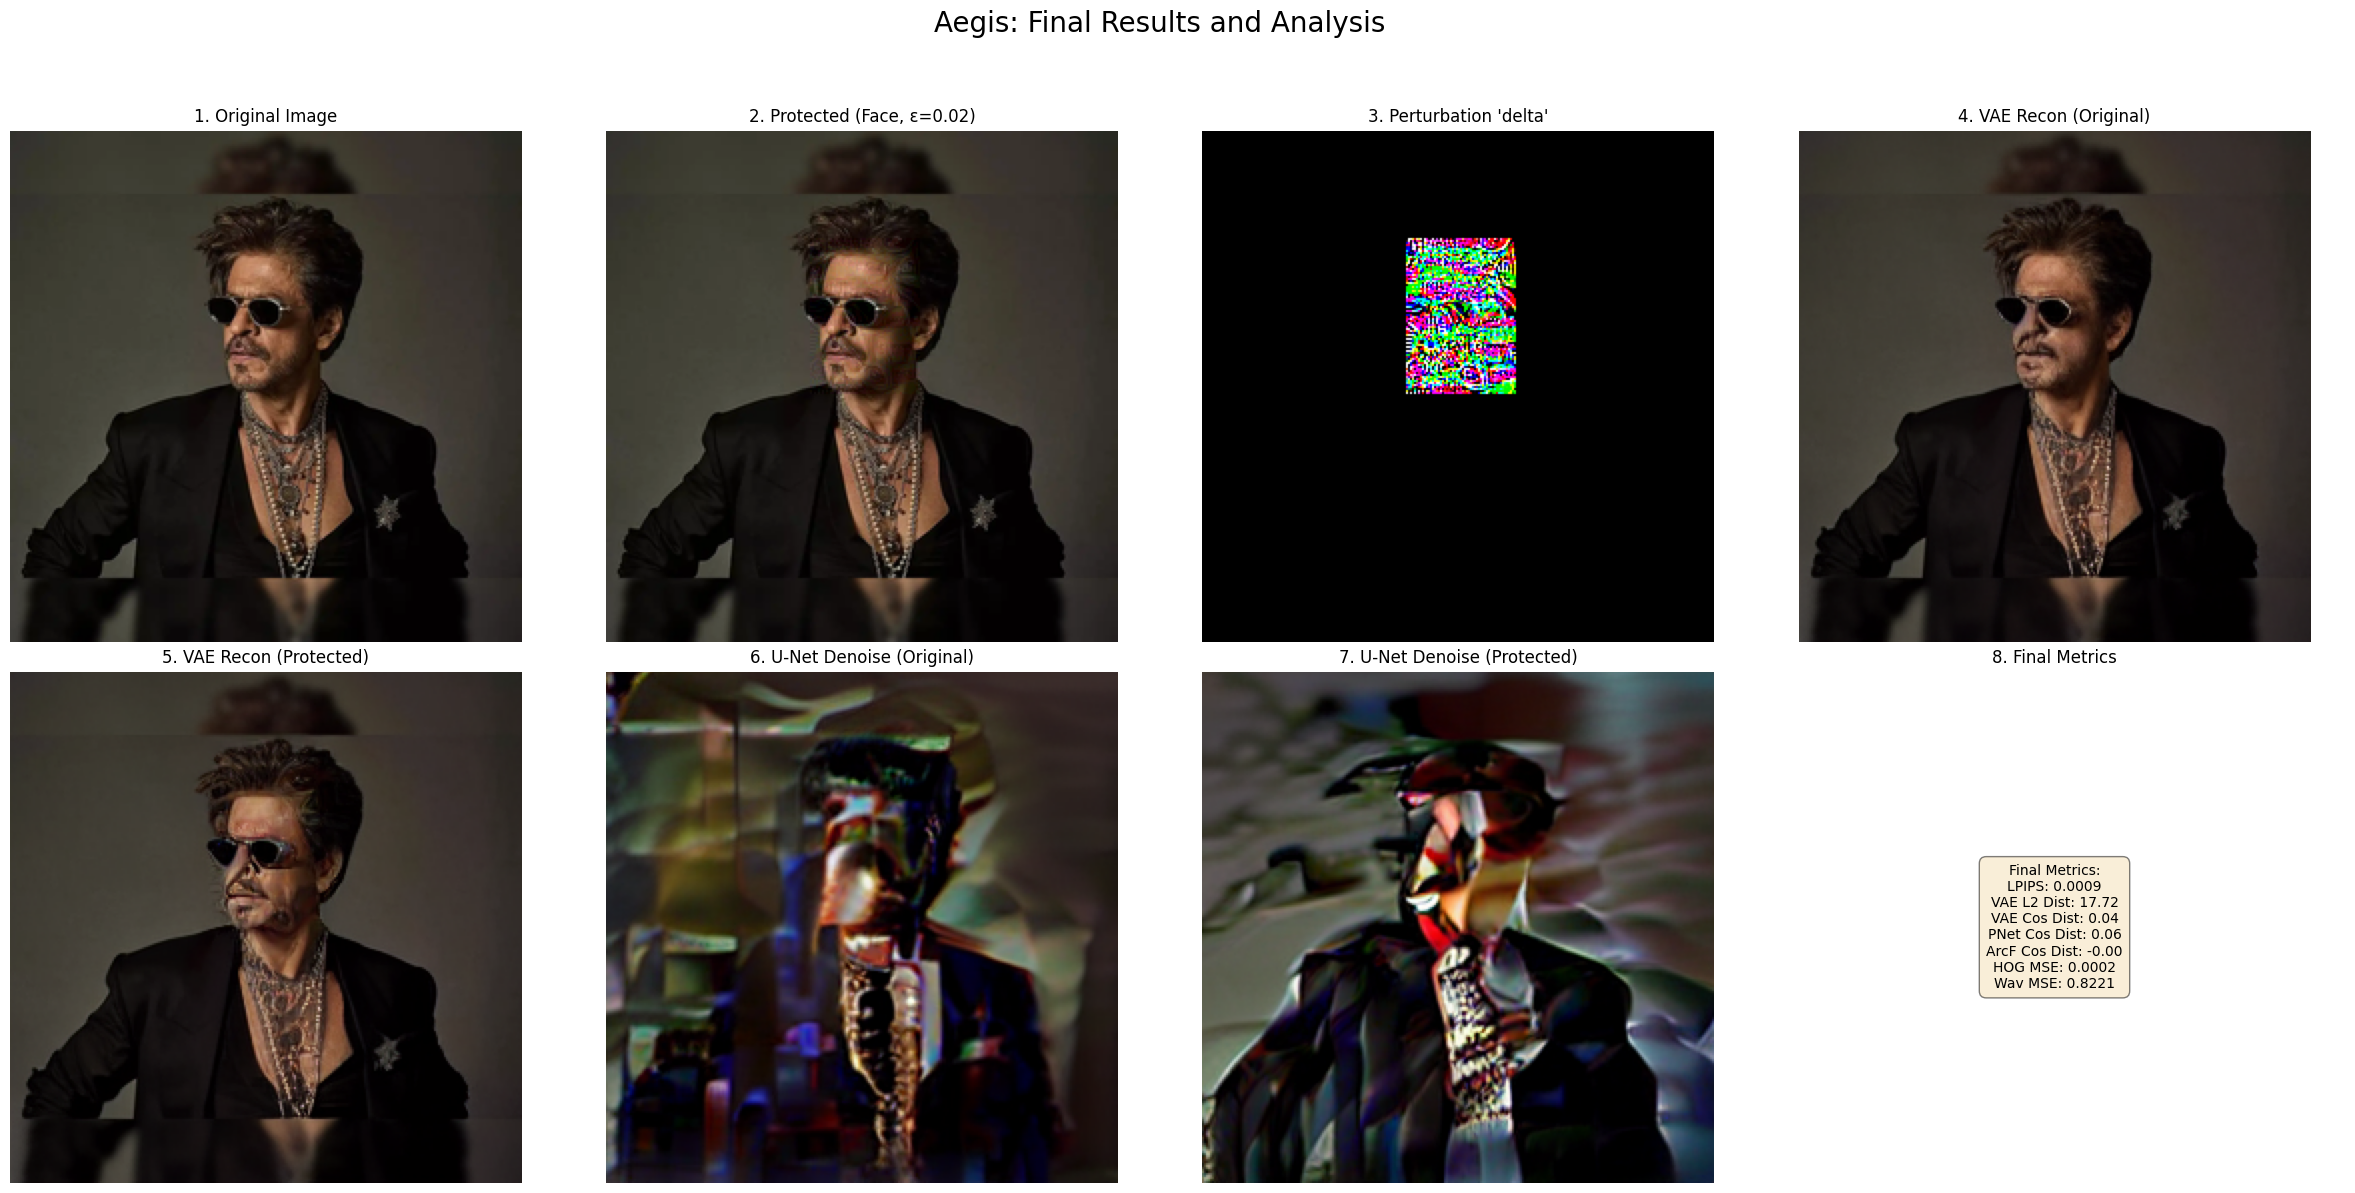


Plotting optimization progress...


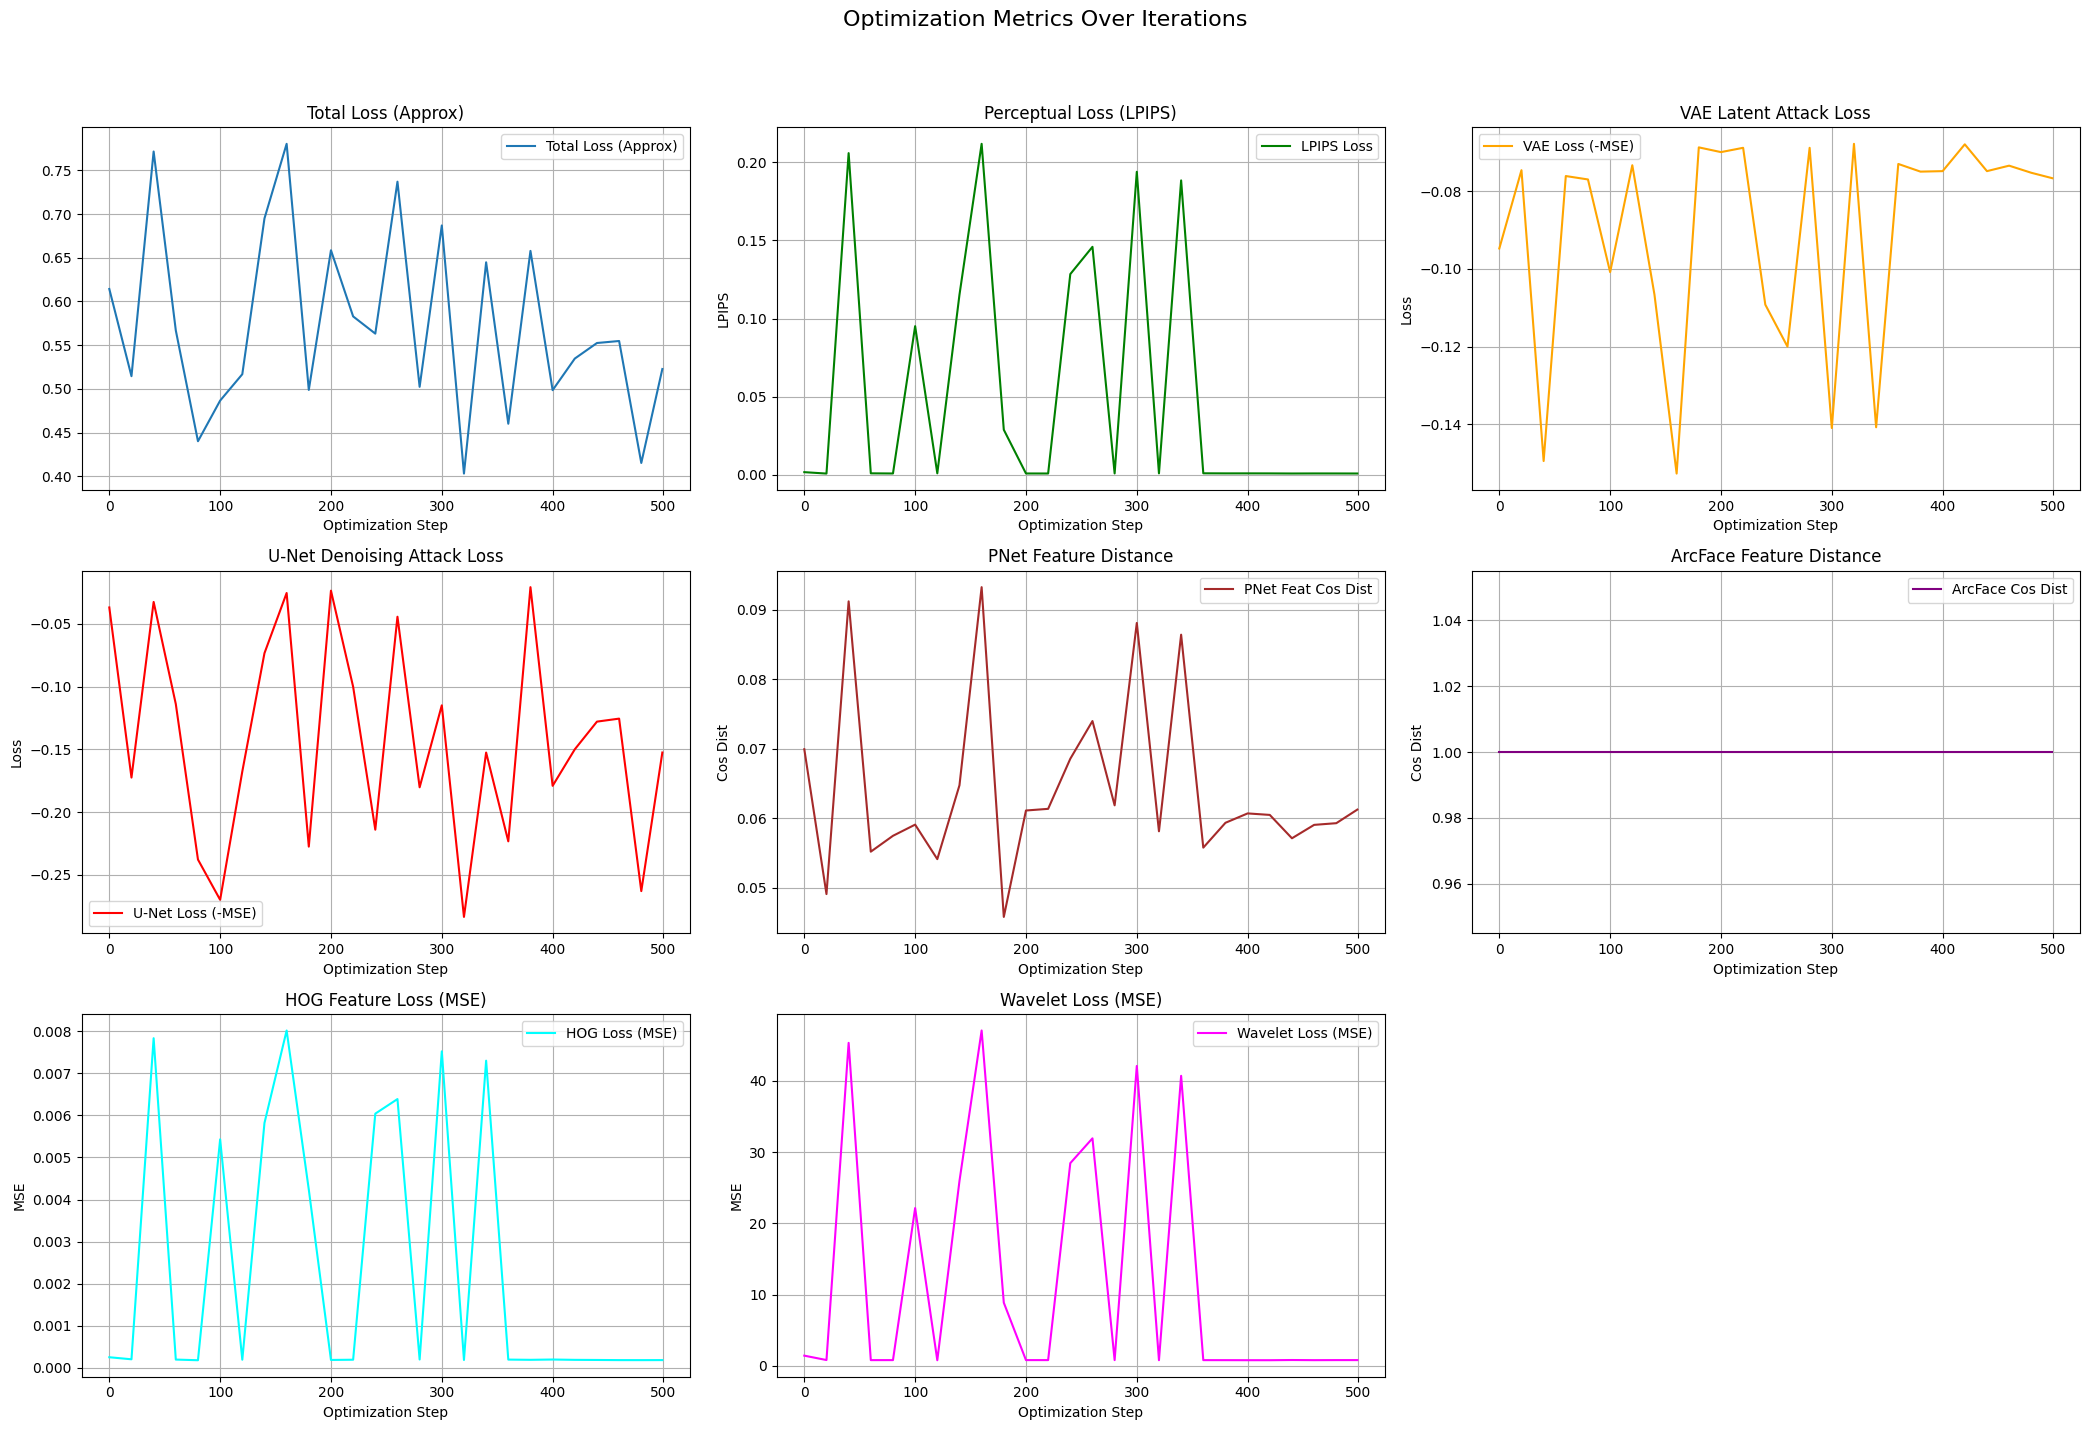


--- Saving Final Results ---
Saved protected image to: /content/drive/MyDrive/BTech_Aegis_Project_PyTorch/output/final_protected_image.png
Saved delta visualization to: /content/drive/MyDrive/BTech_Aegis_Project_PyTorch/output/final_delta_vis.png
Saved VAE reconstruction proof to: /content/drive/MyDrive/BTech_Aegis_Project_PyTorch/output/final_vae_proof.png
Saved U-Net denoising proof to: /content/drive/MyDrive/BTech_Aegis_Project_PyTorch/output/final_unet_proof.png
ERROR during saving: unknown file extension: 

Processing complete.


In [53]:
# === Cell 11: Final Analysis & Visualization ===
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm # Needed for img2img helper
import gc
import math
# Make sure helper functions are available if running this cell standalone
# (Define or re-import to_numpy, tensor_to_pil, normalize_neg1_pos1, denormalize_0_1 etc. if needed)

print("\n--- Final Analysis & Visualization ---")

# --- Recalculate Final Metrics Cleanly ---
final_lpips = 0.0; final_vae_loss = 0.0; final_pnet_loss = 0.0
final_id_loss = -1.0; final_hog_loss = 0.0; final_wavelet_loss = 0.0
final_unet_loss_approx = tracked_unet_loss[-1] if tracked_unet_loss else 0.0 # Get last tracked U-Net loss

with torch.no_grad():
    protected_image_final = torch.clamp(image_tensor + (delta_final * mask_tensor), 0, 1)

    # Recalculate final losses/metrics for reporting accuracy
    if lpips_loss_fn: final_lpips = calculate_lpips_loss(protected_image_final, image_tensor, lpips_loss_fn).item()
    if vae and z_clean is not None: final_vae_loss = calculate_vae_loss(protected_image_final, z_clean, vae, scaling_factor).item() # This is -MSE
    if pnet_feature_extractor and f_clean_pnet_map is not None: final_pnet_loss = calculate_pnet_loss(protected_image_final, pnet_feature_extractor, f_clean_pnet_map).item() # This is CosSim
    if face_app and f_clean_arcface is not None: final_id_loss = calculate_id_loss_monitor(protected_image_final, face_app, f_clean_arcface) # This is CosSim-1
    if 'f_clean_hog' in locals() and f_clean_hog is not None: final_hog_loss = calculate_hog_loss_monitor(protected_image_final, f_clean_hog) # This is MSE
    if 'f_clean_wavelet' in locals() and f_clean_wavelet is not None: final_wavelet_loss = calculate_wavelet_loss_monitor(protected_image_final, f_clean_wavelet) # This is MSE

    # Calculate final distances from losses/similarities
    final_vae_dist_l2 = 0.0 # Need latents to calculate
    final_vae_dist_cos = 0.0
    if vae and z_clean is not None:
         z_poisoned_final = vae.encode(normalize_neg1_pos1(protected_image_final)).latent_dist.mode() * scaling_factor
         z_poisoned_flat_final = z_poisoned_final.view(z_poisoned_final.size(0), -1)
         z_clean_flat = z_clean.view(z_clean.size(0), -1) # Ensure clean is also flat
         final_vae_dist_l2 = torch.norm(z_clean_flat - z_poisoned_flat_final, p=2).item()
         final_vae_dist_cos = 1.0 - F.cosine_similarity(z_clean_flat, z_poisoned_flat_final, dim=1).mean().item()

    # PNet distance = 1 - Similarity
    final_pnet_dist = 1.0 - (final_pnet_loss if W_PNET > 0 else 0.0) # Approx based on loss value being similarity
    # ArcFace distance = 1 - Similarity = 1 - (Loss + 1) = -Loss
    final_id_dist = -(final_id_loss if W_ID == 0.0 and final_id_loss != -1.0 else 0.0) # Approx based on loss value being CosSim-1

# --- Print Final Metrics ---
print("\n--- Final Metrics Summary ---")
print(f" LPIPS (Lower is better): {final_lpips:.4f}")
print(f" VAE Latent L2 Dist (Higher is better): {final_vae_dist_l2:.4f} (Loss: {final_vae_loss:.4f})")
print(f" VAE Latent Cos Dist (Higher is better): {final_vae_dist_cos:.4f}")
print(f" PNet Feat Cos Dist (Approx, Higher is better): {final_pnet_dist:.4f} (Loss/Sim: {final_pnet_loss:.4f})")
print(f" ArcFace Feat Cos Dist (Approx, Higher is better): {final_id_dist:.4f} (Loss/Sim-1: {final_id_loss:.4f})")
print(f" HOG Loss (MSE, Lower means closer): {final_hog_loss:.4f}")
print(f" Wavelet Loss (MSE, Lower means closer): {final_wavelet_loss:.4f}")
print(f" Last Tracked U-Net Loss (-MSE): {final_unet_loss_approx:.4f}")


# --- Generate Visual Proofs ---
print("\nGenerating Visual Proofs...")
with torch.no_grad():
    # VAE Reconstructions
    recon_clean = torch.zeros_like(image_tensor) # Default
    recon_poison = torch.zeros_like(image_tensor)
    if vae and z_clean is not None:
        recon_clean = denormalize_0_1(vae.decode(z_clean / scaling_factor).sample)
        # Recalculate z_poisoned for final viz if not done above
        if 'z_poisoned_final' not in locals():
             z_poisoned_final = vae.encode(normalize_neg1_pos1(protected_image_final)).latent_dist.mode() * scaling_factor
        recon_poison = denormalize_0_1(vae.decode(z_poisoned_final / scaling_factor).sample)
        print("VAE Reconstructions generated.")
    else: print("Skipping VAE Reconstructions (VAE not available).")

    # U-Net Denoising Proofs (Define helper or put logic here)
    denoised_clean = torch.zeros_like(image_tensor)
    denoised_poison = torch.zeros_like(image_tensor)
    # Define img2img helper function (copy from previous script if needed)
    @torch.no_grad()
    def run_img2img_test_latent(input_image, vae_model, unet_model, scheduler_model, null_prompt_tensor, scale_factor, num_steps=50, start_fraction=0.6):
        if vae_model is None or unet_model is None or scheduler_model is None: return torch.zeros_like(input_image)
        # print(f"  Running U-Net Img2Img Proof...")
        img_norm = normalize_neg1_pos1(input_image).to(dtype_attack) # Ensure correct dtype
        z_start = vae_model.encode(img_norm).latent_dist.mode() * scale_factor
        scheduler_model.set_timesteps(num_steps)
        start_timestep_idx = int(num_steps * start_fraction)
        if start_timestep_idx >= len(scheduler_model.timesteps): start_timestep_idx = len(scheduler_model.timesteps) - 1 # Prevent index error
        start_timestep = scheduler_model.timesteps[start_timestep_idx]
        noise = torch.randn_like(z_start).to(device)
        noisy_z = scheduler_model.add_noise(z_start, noise, start_timestep)
        denoised_z = noisy_z
        null_prompt_batch = null_prompt_tensor.repeat(z_start.shape[0], 1, 1)
        # Ensure U-Net is on the correct device for inference
        unet_model.to(device)
        for t in tqdm(scheduler_model.timesteps[start_timestep_idx:], desc="Img2Img Denoising", leave=False):
            noise_pred = unet_model(denoised_z.to(dtype_attack), t, encoder_hidden_states=null_prompt_batch).sample
            denoised_z = scheduler_model.step(noise_pred, t, denoised_z).prev_sample
        # Ensure VAE is on the correct device for decoding
        vae_model.to(device)
        final_latent = denoised_z / scale_factor
        final_img_norm = vae_model.decode(final_latent.to(dtype_attack)).sample
        final_img = denormalize_0_1(final_img_norm)
        # Move models back to CPU if managing memory per function call (optional)
        # unet_model.to(cpu_device); vae_model.to(cpu_device)
        return final_img

    if vae and unet and scheduler:
        print("Generating U-Net Denoising Proof (Original)...")
        denoised_clean = run_img2img_test_latent(image_tensor, vae, unet, scheduler, null_prompt, scaling_factor)
        print("Generating U-Net Denoising Proof (Protected)...")
        denoised_poison = run_img2img_test_latent(protected_image_final, vae, unet, scheduler, null_prompt, scaling_factor)
        print("U-Net Denoising Proofs generated.")
    else: print("Skipping U-Net Denoising Proofs (Models not available).")


# --- Plotting Final Visuals (2x4 grid) ---
print("\nPlotting visual results...")
fig, ax = plt.subplots(2, 4, figsize=(24, 12)) # Adjusted figsize slightly
plt.suptitle("Aegis: Final Results and Analysis", fontsize=20, y=1.02)

# Row 1: Original, Protected, Delta, Clean VAE Recon
ax[0, 0].imshow(to_numpy(image_tensor)); ax[0, 0].set_title("1. Original Image"); ax[0, 0].axis('off')
ax[0, 1].imshow(to_numpy(protected_image_final)); ax[0, 1].set_title(f"2. Protected (Face, ε={EPSILON:.2f})"); ax[0, 1].axis('off')
delta_vis = (delta_final.data.clone() + EPSILON) / (2 * EPSILON); delta_vis *= mask_tensor
ax[0, 2].imshow(to_numpy(delta_vis), cmap='gray'); ax[0, 2].set_title("3. Perturbation 'delta'"); ax[0, 2].axis('off')
ax[0, 3].imshow(to_numpy(recon_clean)); ax[0, 3].set_title("4. VAE Recon (Original)"); ax[0, 3].axis('off')

# Row 2: Poisoned VAE Recon, Clean U-Net Denoise, Poisoned U-Net Denoise, Metrics Text
ax[1, 0].imshow(to_numpy(recon_poison)); ax[1, 0].set_title("5. VAE Recon (Protected)"); ax[1, 0].axis('off')
ax[1, 1].imshow(to_numpy(denoised_clean)); ax[1, 1].set_title("6. U-Net Denoise (Original)"); ax[1, 1].axis('off')
ax[1, 2].imshow(to_numpy(denoised_poison)); ax[1, 2].set_title("7. U-Net Denoise (Protected)"); ax[1, 2].axis('off')
# Format metrics text
metrics_text = (f"Final Metrics:\n"
                f"LPIPS: {final_lpips:.4f}\n"
                f"VAE L2 Dist: {final_vae_dist_l2:.2f}\n"
                f"VAE Cos Dist: {final_vae_dist_cos:.2f}\n"
                f"PNet Cos Dist: {final_pnet_dist:.2f}\n"
                f"ArcF Cos Dist: {final_id_dist:.2f}\n"
                f"HOG MSE: {final_hog_loss:.4f}\n"
                f"Wav MSE: {final_wavelet_loss:.4f}")
ax[1, 3].text(0.5, 0.5, metrics_text, ha='center', va='center', fontsize=10, bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))
ax[1, 3].axis('off'); ax[1, 3].set_title("8. Final Metrics")

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

# === Cell 12: Plot Tracked Metrics ===
# (Plot logged data, adjust grid based on available losses)
print("\nPlotting optimization progress...")
# Determine number of plots needed based on tracked data
num_plots = 1 # Start with total loss
if tracked_lpips_loss: num_plots += 1
if tracked_vae_loss: num_plots += 1
if tracked_unet_loss: num_plots += 1
if tracked_pnet_loss: num_plots += 1
if tracked_id_loss: num_plots += 1 # Actually distance tracked_arcface_dist
if tracked_hog_loss: num_plots += 1
if tracked_wavelet_loss: num_plots += 1

num_cols = 3 # Aim for 3 columns
num_rows = math.ceil(num_plots / num_cols)
fig_metrics, axes = plt.subplots(num_rows, num_cols, figsize=(7*num_cols, 5*num_rows))
if num_rows * num_cols == 1: axes = np.array([[axes]]) # Handle single plot case
elif num_rows == 1 or num_cols == 1: axes = axes.reshape(num_rows, num_cols) # Ensure 2D array
axes_flat = axes.flatten()
plot_idx = 0
plt.suptitle("Optimization Metrics Over Iterations", fontsize=16)

# Plot Total Loss (Approx)
if tracked_total_loss: # Check if list is not empty
     axes_flat[plot_idx].plot(tracked_steps, tracked_total_loss, label='Total Loss (Approx)')
     axes_flat[plot_idx].set_title("Total Loss (Approx)"); plot_idx += 1

# Plot Individual Losses
if tracked_lpips_loss:
    axes_flat[plot_idx].plot(tracked_steps, tracked_lpips_loss, label='LPIPS Loss', color='green')
    axes_flat[plot_idx].set_title("Perceptual Loss (LPIPS)"); axes_flat[plot_idx].set_ylabel("LPIPS"); plot_idx += 1
if tracked_vae_loss:
    axes_flat[plot_idx].plot(tracked_steps, tracked_vae_loss, label='VAE Loss (-MSE)', color='orange')
    axes_flat[plot_idx].set_title("VAE Latent Attack Loss"); axes_flat[plot_idx].set_ylabel("Loss"); plot_idx += 1
if tracked_unet_loss:
    axes_flat[plot_idx].plot(tracked_steps, tracked_unet_loss, label='U-Net Loss (-MSE)', color='red')
    axes_flat[plot_idx].set_title("U-Net Denoising Attack Loss"); axes_flat[plot_idx].set_ylabel("Loss"); plot_idx += 1
if tracked_pnet_loss: # This is Similarity
    tracked_pnet_dist = [1 - s for s in tracked_pnet_loss] # Calculate distance
    axes_flat[plot_idx].plot(tracked_steps, tracked_pnet_dist, label='PNet Feat Cos Dist', color='brown')
    axes_flat[plot_idx].set_title("PNet Feature Distance"); axes_flat[plot_idx].set_ylabel("Cos Dist"); plot_idx += 1
if tracked_id_loss: # This is CosSim-1
    tracked_id_dist = [-s for s in tracked_id_loss] # Distance = -(CosSim-1) = 1-CosSim
    axes_flat[plot_idx].plot(tracked_steps, tracked_id_dist, label='ArcFace Cos Dist', color='purple')
    axes_flat[plot_idx].set_title("ArcFace Feature Distance"); axes_flat[plot_idx].set_ylabel("Cos Dist"); plot_idx += 1
if tracked_hog_loss:
    axes_flat[plot_idx].plot(tracked_steps, tracked_hog_loss, label='HOG Loss (MSE)', color='cyan')
    axes_flat[plot_idx].set_title("HOG Feature Loss (MSE)"); axes_flat[plot_idx].set_ylabel("MSE"); plot_idx += 1
if tracked_wavelet_loss:
    axes_flat[plot_idx].plot(tracked_steps, tracked_wavelet_loss, label='Wavelet Loss (MSE)', color='magenta')
    axes_flat[plot_idx].set_title("Wavelet Loss (MSE)"); axes_flat[plot_idx].set_ylabel("MSE"); plot_idx += 1


# Hide unused axes
for i in range(plot_idx, len(axes_flat)): axes_flat[i].axis('off')
# Common settings
for i in range(plot_idx): axes_flat[i].set_xlabel("Optimization Step"); axes_flat[i].legend(); axes_flat[i].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# === Cell 13: Saving Results ===
print("\n--- Saving Final Results ---")
try:
    # Ensure helper functions are available
    if 'tensor_to_pil' not in locals():
        def to_numpy(img_tensor): # Simplified version for saving
            if img_tensor.dtype != torch.float32: img_tensor = img_tensor.float()
            if img_tensor.dim() == 4: img_tensor = img_tensor[0]
            img_np=img_tensor.permute(1,2,0).clamp(0,1).mul(255).byte().cpu().numpy()
            return img_np
        def tensor_to_pil(img_tensor): return Image.fromarray(to_numpy(img_tensor))

    # Convert final tensors to PIL images
    pil_protected = tensor_to_pil(protected_image_final)
    pil_delta_vis = tensor_to_pil(delta_vis)
    pil_recon_poison = tensor_to_pil(recon_poison)
    pil_denoise_poison = tensor_to_pil(denoised_poison)

    # Define output paths
    protected_path = os.path.join(OUTPUT_PATH, "final_protected_image.png")
    delta_path = os.path.join(OUTPUT_PATH, "final_delta_vis.png")
    recon_path = os.path.join(OUTPUT_PATH, "final_vae_proof.png")
    denoise_path = os.path.join(OUTPUT_PATH, "final_unet_proof.png")
    plot_path = os.path.join(OUTPUT_PATH, "final_analysis_plot.png")
    metrics_plot_path = os.path.join(OUTPUT_PATH, "final_metrics_plot.png")

    # Save images
    pil_protected.save(protected_path)
    pil_delta_vis.save(delta_path)
    pil_recon_poison.save(recon_path)
    pil_denoise_poison.save(denoise_path)
    print(f"Saved protected image to: {protected_path}")
    print(f"Saved delta visualization to: {delta_path}")
    print(f"Saved VAE reconstruction proof to: {recon_path}")
    print(f"Saved U-Net denoising proof to: {denoise_path}")


    pil_protected.save("/content/")
    pil_delta_vis.save("/content/")
    pil_recon_poison.save("/content/")
    pil_denoise_poison.save("/content/")
    # Save the figures
    fig.savefig(plot_path, bbox_inches='tight')
    fig_metrics.savefig(metrics_plot_path, bbox_inches='tight')
    print(f"Saved analysis plot to: {plot_path}")
    print(f"Saved metrics plot to: {metrics_plot_path}")

except Exception as e:
    print(f"ERROR during saving: {e}")

print("\nProcessing complete.")